In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlite3
import pandas as pd
#from scipy.stats import crystalball, chi2
#from iminuit import Minuit
import matplotlib.colors as mcolors
#from iminuit.util import make_func_code
#from iminuit import describe #, Minuit,
# Set custom color cycle
custom_colors = [    
    '#0081C8',  # Olynmpic Blue
    '#FCB131', # Olympic Yellow
    '#000000', # Olympic Black
    '#00A651',  # Olympic Green
    '#EE334E',  # Olynmpic Red
    '#F47835',  # Olympic Orange
    '#7C878E',  # Olympic Grey
    '#C8102E',  # Olympic Red
    '#EF3340',  # Olympic Red
    '#FFD662',  # Olympic Yellow
    '#00539C',  # Olympic Blue
]

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=custom_colors)


In [2]:
import sys
sys.path.append('/groups/icecube/simon/GNN/workspace/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax


In [3]:
gcd_file_path = "/lustre/hpc/project/icecube/MuonGun_upgrade_full_detector_generation_volume_no_kde/130028/GCD/GeoCalibDetectorStatus_ICUpgrade.v58.mixed.V1.i3.bz2"

In [4]:
pd.set_option('display.max_columns', None)
#load the filtered data from the new database
file_path ='/groups/icecube/simon/GNN/workspace/filtered.db'
con = sqlite3.connect(file_path)
df_truth = pd.read_sql_query("SELECT * FROM truth", con)
df_splits = pd.read_sql_query("SELECT * FROM SplitInIcePulsesSRT", con)
df_splits.head()



,index,pmt_dir_x,pmt_dir_y,pmt_dir_z,charge,dom_time,width,dom_x,dom_y,dom_z,pmt_area,rde,is_bright_dom,is_bad_dom,is_saturated_dom,is_errata_dom,event_time,hlc,awtd,string,pmt_number,dom_number,dom_type,event_no
0,397,-0.363954,0.878662,0.309017,1.242958,10098.663534,2.0,57.238209,-83.559966,-292.868527,0.008171,1.0,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,90.0,6.0,47.0,130.0,10
1,398,-0.363954,0.878662,0.309017,1.164914,10162.209496,2.0,57.238209,-83.559966,-292.868527,0.008171,1.0,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,90.0,6.0,47.0,130.0,10
2,399,-0.363954,0.878662,0.309017,0.641547,10166.275581,2.0,57.238209,-83.559966,-292.868527,0.008171,1.0,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,90.0,6.0,47.0,130.0,10
3,400,-0.363954,0.878662,0.309017,1.394020,10171.614545,2.0,57.238209,-83.559966,-292.868527,0.008171,1.0,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,90.0,6.0,47.0,130.0,10
4,401,-0.363954,0.878662,0.309017,0.745153,10312.183035,2.0,57.238209,-83.559966,-292.868527,0.008171,1.0,-1.0,-1.0,-1.0,-1.0,59000.171844,1.0,1.0,90.0,6.0,47.0,130.0,10


In [5]:
z_start = -13.792029 + 642.896244*np.cos(0.810170)
x_start = -304.682738 + 642.896244*np.sin(0.810170)*np.cos(4.164466)
y_start = -185.969129 + 642.896244*np.sin(0.810170)*np.sin(4.164466)

print(x_start, y_start, z_start)

x_end = -547.2818 + 642.896244*np.sin(np.pi - 0.810170)*np.cos(4.164466- np.pi)
y_end =  -583.508907 + 642.896244*np.sin(np.pi - 0.810170)*np.sin(4.164466- np.pi)
z_end = 429.40475 + 642.896244*np.cos(np.pi - 0.810170)
print(x_end, y_end, z_end)

-547.2818159315518 -583.5089076866981 429.40475832793123
-304.6827220684482 -185.96912831330195 -13.792037327931268


In [6]:
df_splits.head()
#Print the max dom_number and the max string number

#print(df_splits['dom_number'].max())
#print x,y,z of dom with max dom_number
#print(df_splits[df_splits['dom_number'] == 60])
#print(df_splits['string'].max())
print(len(df_splits['dom_number'].unique()))


116


In [7]:
# Constants
c = 0.299792458  # Speed of light in vacuum (m/ns)
n_ice = 1.34  # Refractive index of ice
v_photon = c / n_ice  # Speed of light in ice
v_muon = 0.98 * c  # Muon velocity (assumed to be close to the speed of light)
theta_c = np.arccos(1 / n_ice)  # Cherenkov angle in radians


In [8]:
# Count the amount of events in the truth data #151148
n_events = len(df_truth['event_no'].unique())
print(f"Number of events: {n_events}")

# Number of events without a mask 665742, after mask is applied 151148

Number of events: 151148


In [9]:
x_dom, y_dom, z_dom = df_splits['dom_x'].values, df_splits['dom_y'].values, df_splits['dom_z'].values
charge = df_splits['charge'].values
#start_time = df_truth['Time_Prim'].values
charge_time = df_splits['dom_time'].values
x, y, z = df_truth['position_x'].values, df_truth['position_y'].values, df_truth['position_z'].values
energy = df_truth['energy'].values
track_length = df_truth['track_length'].values
zenith, azimuth = df_truth['zenith'].values, df_truth['azimuth'].values


Number of events in HQE data: 37797


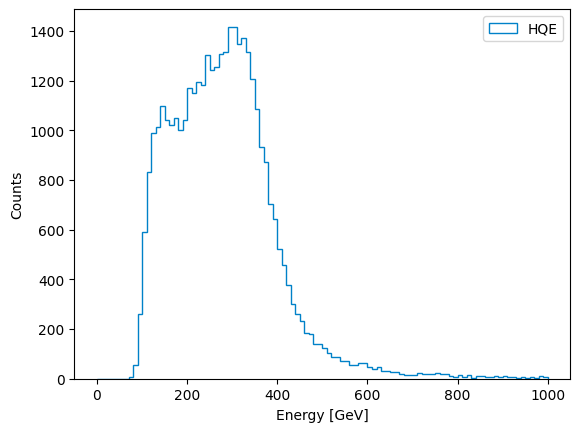

Text(0, 0.5, 'Counts')

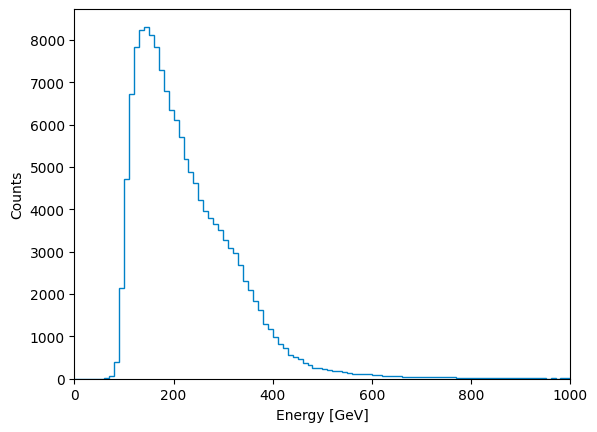

In [10]:
#Plot the energy distribution for events which trigger hqe_data = df_splits[df_splits['rde'] == 1.35]
hqe_data = df_splits[df_splits['rde'] == 1.35]
hqe_eventno = hqe_data['event_no'].unique()
hqe_truth = df_truth[df_truth['event_no'].isin(hqe_eventno)]
#Find the unique event numbers in the hqe_truth data
hqe_energy = hqe_truth['energy'].values
print(f"Number of events in HQE data: {len(hqe_energy)}")
plt.hist(hqe_energy, bins=100, range = (0, 1000), histtype='step', label='HQE')
plt.xlabel('Energy [GeV]')
plt.ylabel('Counts')
plt.legend()
plt.show()

plt.hist(energy, bins=100, range = (0,1000), histtype='step', label='All events')
plt.xlabel('Energy [GeV]')
plt.xlim(0,1000)
plt.ylabel('Counts')


In [11]:
# Define DeepCore fiducial volume parameters
deepcore_origin = np.array([46.29, -34.88, -330.0])  # Origin of the cylinder (x, y, z)
deepcore_radius = 150.0  # Radius of the cylinder in the XY plane
z_min, z_max = -511.93000000000006, -151.93000000000006  # Z-range of the cylinder

def is_inside_deepcore(position):
    """
    Check if a given position is within the DeepCore fiducial volume.
    
    Parameters:
    - position: numpy array containing (x, y, z) coordinates of the particle's stopping point.
    
    Returns:
    - bool: True if the position is within the DeepCore volume, False otherwise.
    """
    # Calculate radial distance in the XY plane from the DeepCore origin
    xy_distance = np.linalg.norm(position[:2] - deepcore_origin[:2])
    
    # Check if position is within both the radial and z constraints of the DeepCore volume
    if xy_distance <= deepcore_radius and z_min <= position[2] <= z_max:
        return True
    return False

def count_and_record_particles_stopping_in_deepcore(df_secondary):
    """
    Count particles that stop within the DeepCore fiducial volume and record their event numbers.
    
    Parameters:
    - df_secondary: DataFrame containing the stopping positions of particles.
    
    Returns:
    - tuple: (int, list) where the int is the number of particles that stop inside the DeepCore volume,
             and the list contains the event numbers of these particles.
    """
    count = 0
    stopping_event_nos = []
    
    for index, row in df_secondary.iterrows():
        # Get the stopping position of the particle (adjust column names as needed)
        stop_position = np.array([row['position_x'], row['position_y'], row['position_z']])
        #azimuth, zenith, track_length = row['azimuth'], row['zenith'], row['track_length']
        #stop_position = start_position + np.array([track_length * np.sin(zenith) * np.cos(azimuth),
        #                                           track_length * np.sin(zenith) * np.sin(azimuth),
        #                                           track_length * np.cos(np.pi - zenith)])
        
        
        
        # Check if the particle stops within the DeepCore volume
        if is_inside_deepcore(stop_position):
            count += 1  # Particle stops within the DeepCore volume
            stopping_event_nos.append(row['event_no'])  # Record the event number

    return count, stopping_event_nos

count, event_nos = count_and_record_particles_stopping_in_deepcore(df_truth)
print(f"Number of particles stopping in DeepCore: {count}")
print(f"Event numbers of particles stopping in DeepCore: {event_nos}")


Number of particles stopping in DeepCore: 13019
Event numbers of particles stopping in DeepCore: [38, 50, 55, 167, 184, 232, 234, 297, 320, 610, 642, 783, 820, 829, 892, 909, 1093, 1123, 1198, 1267, 1321, 1324, 1357, 1419, 1448, 1599, 1649, 1687, 1745, 1746, 1797, 1877, 1885, 1888, 1981, 1982, 2101, 2114, 2116, 2131, 2209, 2211, 2241, 2366, 2404, 2521, 2621, 2709, 2733, 2787, 2818, 2858, 2894, 2940, 2971, 3002, 3049, 3105, 3180, 3214, 3216, 3253, 3296, 3330, 3452, 3498, 3560, 3573, 3653, 3876, 3923, 4088, 4089, 4111, 4165, 4196, 4258, 4269, 4298, 4323, 4374, 4519, 4536, 4574, 4603, 4606, 4658, 4707, 4830, 4838, 4858, 4898, 4917, 4952, 4969, 4985, 5025, 5077, 5136, 5197, 5267, 5438, 5442, 5509, 5537, 5692, 5713, 5828, 5871, 5872, 5928, 5984, 5985, 6062, 6111, 6122, 6153, 6287, 6315, 6364, 6407, 6459, 6508, 6533, 6536, 6540, 6703, 6767, 6901, 6924, 6965, 7004, 7006, 7026, 7110, 7165, 7228, 7265, 7311, 7352, 7369, 7375, 7387, 7404, 7437, 7467, 7496, 7522, 7670, 7757, 7774, 7882, 7908, 793

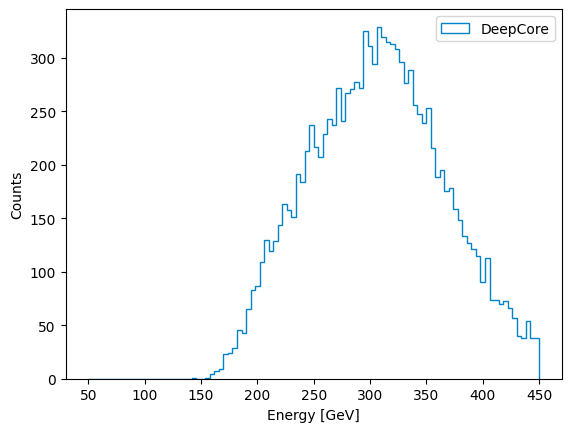

In [12]:
# Make a energy histogram of the particles stopping in DeepCore
deepcore_data = df_truth[df_truth['event_no'].isin(event_nos)]
deepcore_energy = deepcore_data['energy'].values
plt.hist(deepcore_energy, bins=100, range=(50, 450), histtype='step', label='DeepCore')
plt.xlabel('Energy [GeV]')
plt.ylabel('Counts')
plt.legend()
plt.show()


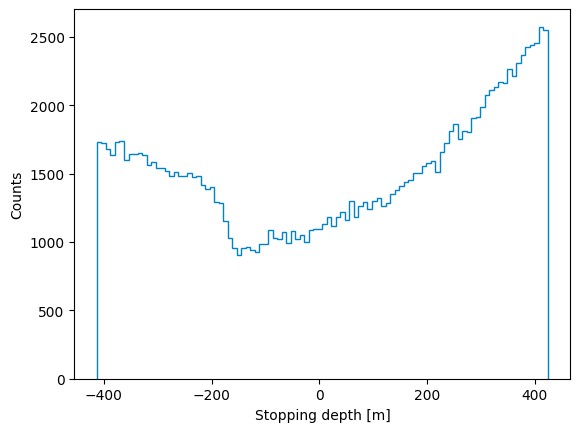

424.5550708230281


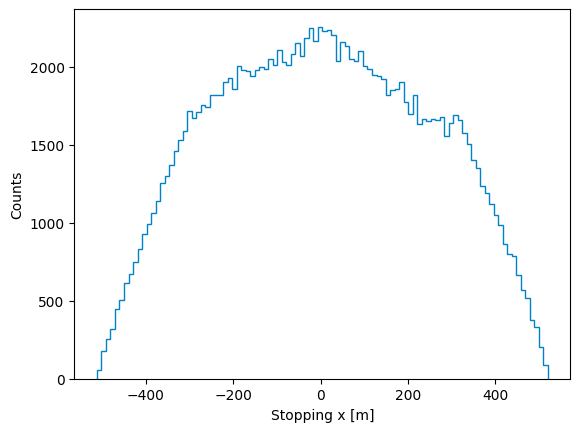

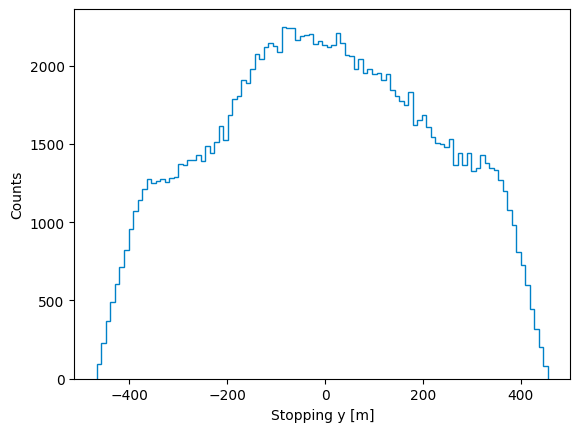

In [13]:
#Make a plot of the stopping positionss depth distribution
#Calculate the stopping depth of each particle
stopping_depths = df_truth['position_z'] + (df_truth['track_length'] * np.cos(np.pi-df_truth['zenith']))
starting_depths = df_truth['position_z']
#plt.hist(stopping_depths, bins=100, histtype='step')
plt.hist(starting_depths, bins=100, histtype='step')
plt.xlabel('Stopping depth [m]')
plt.ylabel('Counts')
plt.show()
print(df_truth['position_z'].max())

#stopping_x = df_truth['position_x'] + (df_truth['track_length'] * np.sin(np.pi-df_truth['zenith']) * np.cos(df_truth['azimuth']-np.pi))
#stopping_x_corrected = df_truth['position_x'] + (df_truth['track_length'] * np.sin(df_truth['zenith']) * np.cos(df_truth['azimuth']))

plt.hist(df_truth['position_x'], bins=100, histtype='step')
#plt.hist(stopping_x_corrected, bins=100, histtype='step')
plt.xlabel('Stopping x [m]')
plt.ylabel('Counts')
plt.show()

stoppping_y = df_truth['position_y'] + (df_truth['track_length'] * np.sin(np.pi-df_truth['zenith']) * np.sin(df_truth['azimuth']-np.pi))
#stopping_y_corrected = df_truth['position_y'] + (df_truth['track_length'] * np.sin(df_truth['zenith']) * np.sin(df_truth['azimuth']-np.pi))
plt.hist(df_truth['position_y'], bins=100, histtype='step')
#plt.hist(stopping_y_corrected, bins=100, histtype='step')
plt.xlabel('Stopping y [m]')
plt.ylabel('Counts')
plt.show()


In [14]:
#Convert df_completed to a csv file
df_grid = df_splits[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].drop_duplicates()
df_grid.to_csv('completed.csv', index=False)


Number of unique dom positions: 93


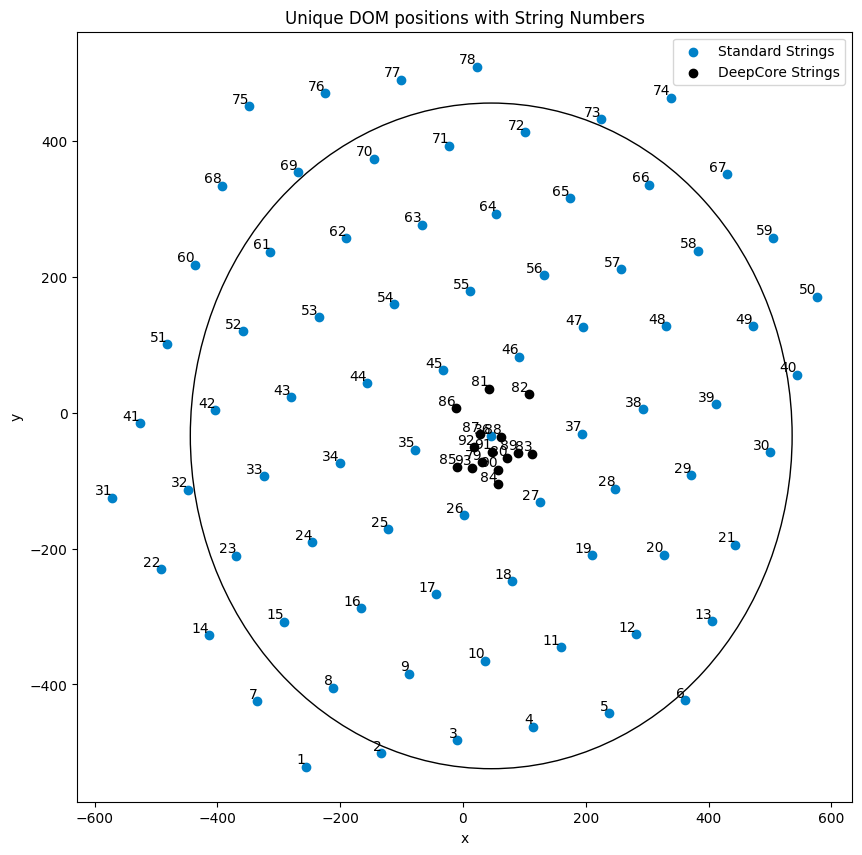

In [21]:
def plotXYpositionsWithLabels(df):
    unique_dom_xy = df.groupby(['string']).first().reset_index()
    print(f'Number of unique dom positions: {unique_dom_xy.shape[0]}')
    standardString = unique_dom_xy[unique_dom_xy['string'] <79]
    deepCoreString = unique_dom_xy[unique_dom_xy['string'] >= 79]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(standardString['dom_x'], standardString['dom_y'], marker='o', color = custom_colors[0], label='Standard Strings')
    ax.scatter(deepCoreString['dom_x'], deepCoreString['dom_y'], marker='o', color = custom_colors[2], label='DeepCore Strings')
    
    for _, row in unique_dom_xy.iterrows():
        ax.text(row['dom_x'], row['dom_y'], str(int(row['string'])), fontsize=10, ha='right', va='bottom')
    #Draw a circle of radius 400 m from y_m: -34, x_m: 46
    circle = plt.Circle((46, -34), 490, color='black', fill=False)
    
    ax.add_artist(circle)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Unique DOM positions with String Numbers')
    ax.legend()
    
df_grid = df_splits[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].drop_duplicates()
plotXYpositionsWithLabels(df_grid)


       string  dom_number           x           y           z
0        90.0        47.0   57.238209  -83.559966 -292.868527
1        90.0        54.0   57.415034  -83.736791 -313.868527
2        93.0        47.0   14.341791  -80.688784 -292.991473
3        93.0        50.0   14.238209  -80.438716 -301.868527
4        13.0        19.0  405.830000 -306.380000  188.760000
...       ...         ...         ...         ...         ...
15252    93.0       121.0   14.290000  -80.563750 -601.683000
15253    23.0        60.0 -368.930000 -210.230000 -503.690000
15254    20.0        60.0  326.850000 -209.070000 -505.800000
15255    68.0        59.0 -392.380000  334.240000 -484.410000
15256     2.0        58.0 -132.800000 -501.450000 -470.110000

[15257 rows x 5 columns]


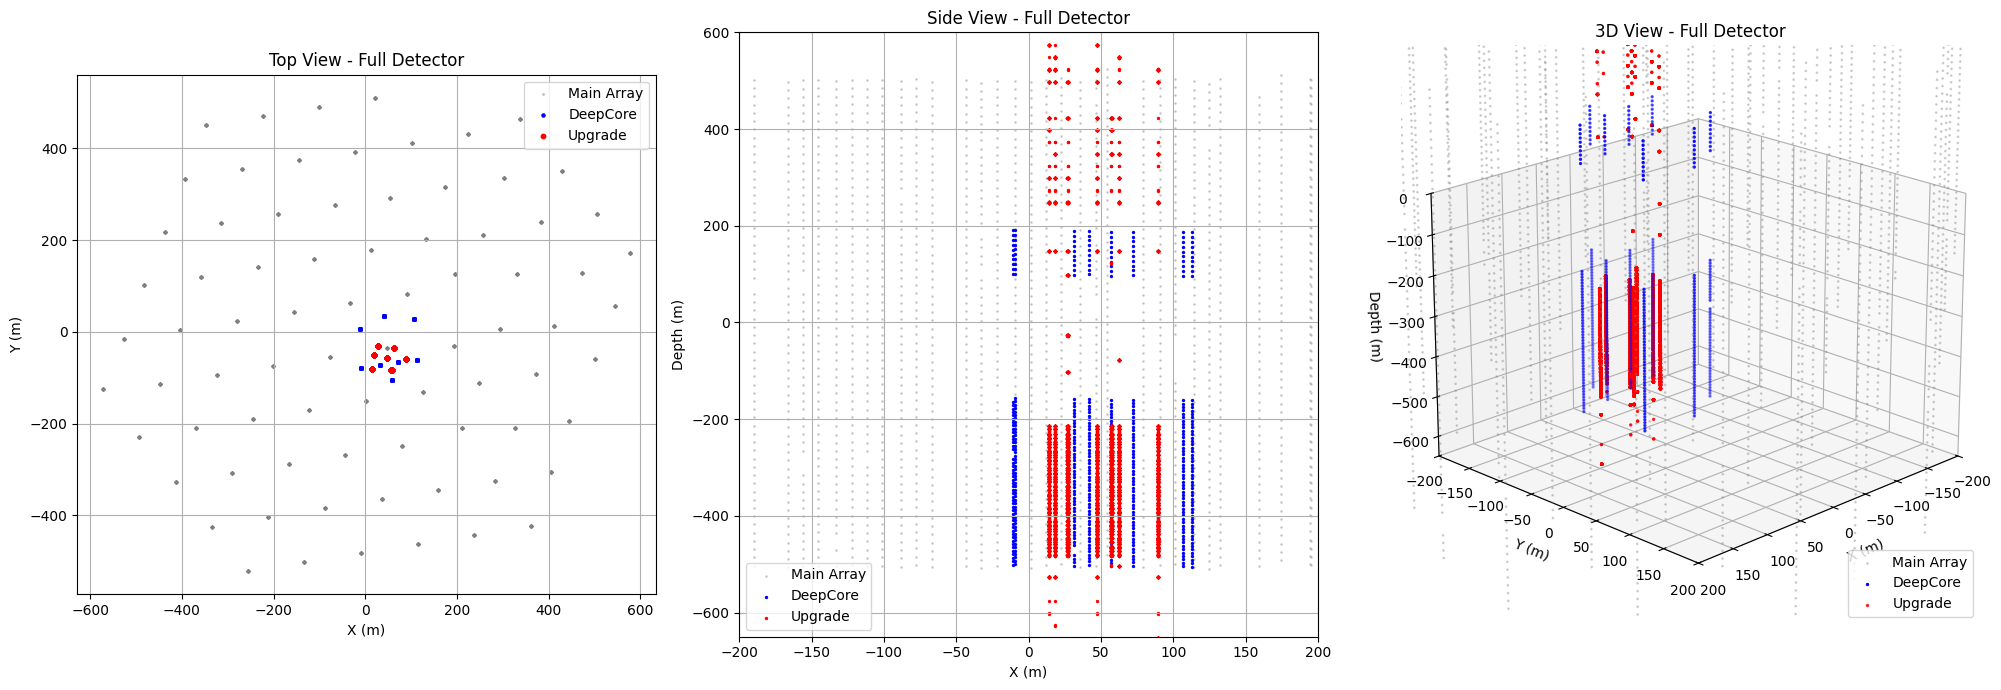


Detector Statistics:
Main Array DOMs (strings 1-78): 4564
DeepCore DOMs (strings 79-86): 475
Upgrade DOMs (strings 87+): 10218

Upgrade String Positions:

String 87.0:
- Number of DOMs: 1471
- Depth range: -482.1m to 523.3m
- Position: (27.0m, -31.2m)

String 88.0:
- Number of DOMs: 1473
- Depth range: -503.1m to 548.2m
- Position: (62.6m, -35.2m)

String 89.0:
- Number of DOMs: 1450
- Depth range: -652.1m to 523.2m
- Position: (89.3m, -59.0m)

String 90.0:
- Number of DOMs: 1353
- Depth range: -503.2m to 423.2m
- Position: (57.3m, -83.7m)

String 91.0:
- Number of DOMs: 1522
- Depth range: -602.2m to 573.2m
- Position: (47.3m, -57.0m)

String 92.0:
- Number of DOMs: 1474
- Depth range: -627.2m to 573.1m
- Position: (18.3m, -51.1m)

String 93.0:
- Number of DOMs: 1475
- Depth range: -602.2m to 573.2m
- Position: (14.3m, -80.6m)


In [35]:
def analyze_full_detector():
    # Load both geometries to compare
   # df_original = pd.read_csv(geo_file)
    df_upgrade = pd.read_csv('/groups/icecube/simon/GNN/workspace/completed.csv',
                            sep=',',
                            skiprows=1,
                            names=['string', 'dom_number', 'x', 'y', 'z'])
    print(df_upgrade)
    # Filter out very shallow DOMs for better visualization
    df_filtered = df_upgrade[df_upgrade['z'] < 600]
    # Define upgrade region
    min_depth = -700
    max_depth = 600
    # Create plots
    fig = plt.figure(figsize=(20, 7))
    # Top view
    ax1 = fig.add_subplot(131)
    # Plot strings with adjusted sizes
    main_array = df_filtered[df_filtered['string'].between(1, 78)]
    deepcore = df_filtered[df_filtered['string'].between(79, 86)]
    upgrade = df_filtered[df_filtered['string'] >= 87]
    special = df_filtered[df_filtered['string'] == 0]
    # Plot with meaningful labels and smaller points
    ax1.scatter(main_array['x'], main_array['y'], c='gray', s=2, alpha=0.3, label='Main Array')
    ax1.scatter(deepcore['x'], deepcore['y'], c='blue', s=5, label='DeepCore')
    ax1.scatter(upgrade['x'], upgrade['y'], c='red', s=10, label='Upgrade')
    if len(special) > 0:
        ax1.scatter(special['x'], special['y'], c='green', s=10, label='Special (String 0)')
    ax1.grid(True)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Top View - Full Detector')
    ax1.legend()
    # Set equal aspect ratio and zoom to DeepCore/Upgrade region
    ax1.set_aspect('equal')
    center_x = upgrade['x'].mean()
    center_y = upgrade['y'].mean()
    # ax1.set_xlim(center_x - 100, center_x + 100)
    # ax1.set_ylim(center_y - 100, center_y + 100)
    
    # Side view
    ax2 = fig.add_subplot(132)
    ax2.scatter(main_array['x'], main_array['z'], s=1, c='gray', alpha=0.3, label='Main Array')
    ax2.scatter(deepcore['x'], deepcore['z'], s=2, c='blue', label='DeepCore')
    ax2.scatter(upgrade['x'], upgrade['z'], s=2, c='red', label='Upgrade')
    if len(special) > 0:
        ax2.scatter(special['x'], special['z'], s=4, c='green', label='Special (String 0)')
    # Show upgrade region
    #ax2.axhspan(min_depth, max_depth, color='red', alpha=0.1, label='Upgrade region')
    ax2.grid(True)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Depth (m)')
    ax2.set_ylim(-650, 600)
    ax2.set_xlim(-200, 200)
    ax2.set_title('Side View - Full Detector')
    ax2.legend()
    # 3D visualization
    ax3 = fig.add_subplot(133, projection='3d')
    # Plot existing DOMs
    ax3.scatter(main_array['x'], main_array['y'], main_array['z'],
                s=1, c='gray', alpha=0.3, label='Main Array')
    ax3.scatter(deepcore['x'], deepcore['y'], deepcore['z'],
                s=2, c='blue', label='DeepCore')
    ax3.scatter(upgrade['x'], upgrade['y'], upgrade['z'],
                s=2, c='red', alpha=0.8, label='Upgrade')
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    ax3.set_zlabel('Depth (m)')
    ax3.set_title('3D View - Full Detector')
    ax3.set_zlim(-650,0)
    ax3.set_xlim(-200, 200)
    ax3.set_ylim(-200, 200)
    ax3.legend()
    # Rotate the 3D view for better visualization
    ax3.view_init(elev=20, azim=45)
    plt.tight_layout()
    plt.show()
    # Print statistics
    print("\nDetector Statistics:")
    print(f"Main Array DOMs (strings 1-78): {len(main_array)}")
    print(f"DeepCore DOMs (strings 79-86): {len(deepcore)}")
    print(f"Upgrade DOMs (strings 87+): {len(upgrade)}")
    print("\nUpgrade String Positions:")
    for string in sorted(upgrade['string'].unique()):
        string_data = upgrade[upgrade['string'] == string]
        print(f"\nString {string}:")
        print(f"- Number of DOMs: {len(string_data)}")
        print(f"- Depth range: {string_data['z'].min():.1f}m to {string_data['z'].max():.1f}m")
        print(f"- Position: ({string_data['x'].mean():.1f}m, {string_data['y'].mean():.1f}m)") 
analyze_full_detector()

In [36]:

def calculate_photon_distance(P_DOM, P1, P2, theta_Cher):
    """
    Calculate the distance from the Cherenkov emission point to the DOM.

    Parameters:
    - P_DOM: Position of the DOM (3D vector).
    - P1: Start point of the muon (3D vector).
    - P2: End point of the muon (3D vector).
    - theta_Cher: Cherenkov angle in radians.

    Returns:
    - photon_distance: Distance from P_Cherenkov to P_DOM.
    - P_Cherenkov: Position of the Cherenkov emission point.
    """
    # Calculate the muon track direction vector and its length
    muon_dir = P2 - P1
    muon_length = np.linalg.norm(muon_dir)
    
    # Normalize the muon direction vector
    muon_dir_unit = muon_dir / muon_length
    
    # Calculate vector from P2 to P_DOM and projection length `n` on muon direction
    vec_P1_DOM = P1- P_DOM
    projection_length = np.dot(vec_P1_DOM, muon_dir_unit)  # Projection of P2->DOM on muon_dir
    
    # Calculate P_DOCA using the normalized projection
    P_DOCA = P1 - projection_length * muon_dir_unit  # Closest point on the track
    
    # Distance from P_DOCA to P_DOM
    d_DOCA = np.linalg.norm(P_DOM - P_DOCA)
    
    # Distance from P_DOCA to P_Cherenkov
    distance_to_P_Cherenkov = d_DOCA * np.tan(theta_Cher)
    
    # Calculate `r` in terms of muon direction units
    r = distance_to_P_Cherenkov / muon_length
    
    # Calculate P_Cherenkov position
    P_Cherenkov = P_DOCA - r * muon_dir
    
    # Photon distance from P_Cherenkov to P_DOM
    photon_distance = np.linalg.norm(P_DOM - P_Cherenkov)
    
    return photon_distance, P_Cherenkov

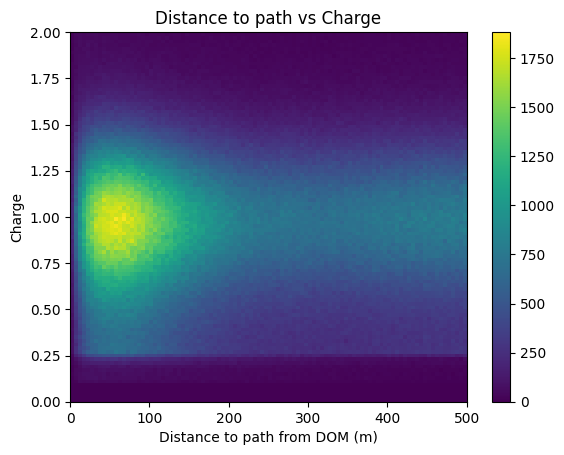

count    6.777049e+06
mean     3.843775e+02
std      2.693467e+02
min      6.045418e-02
25%      1.276412e+02
50%      3.576560e+02
75%      6.160474e+02
max      1.351318e+03
Name: distance_to_path, dtype: float64


In [37]:
def calculate_path(df):
    x_end = df['position_x']
    y_end = df['position_y']
    z_end = df['position_z']
    zenith = df['zenith']
    azimuth = df['azimuth']
    track_length = df['track_length']
    
    x_start = x + track_length * np.sin(zenith) * np.cos(azimuth)
    y_start = y + track_length * np.sin(zenith) * np.sin(azimuth)
    z_start = z + track_length * np.cos(zenith)
    return x_start, y_start, z_start
# Merge df_splits with necessary columns from df_truth
df_merged = pd.merge(df_splits, df_truth[['event_no', 'position_x', 'position_y', 'position_z', 'zenith', 'azimuth', 'track_length']], on='event_no')

# Vectorized function to calculate distance of DOM from the particle path
def calculate_distance_to_path_vectorized(df):
    # Coordinates of DOMs
    x_dom = df['dom_x'].values
    y_dom = df['dom_y'].values
    z_dom = df['dom_z'].values
    
    # Coordinates of the particle path start and end
    x_end = df['position_x'].values  # End position directly from data
    y_end = df['position_y'].values
    z_end = df['position_z'].values
    
    # Calculate start positions directly within the function
    start_positions = df.apply(lambda row: calculate_start_position(row), axis=1)
    x_start, y_start, z_start = zip(*start_positions)
    x_start, y_start, z_start = np.array(x_start), np.array(y_start), np.array(z_start)

    # Vectors along the path and to the DOM
    path_vec = np.vstack([x_end - x_start, y_end - y_start, z_end - z_start]).T
    dom_vec = np.vstack([x_dom - x_start, y_dom - y_start, z_dom - z_start]).T
    
    # Length and unit vector along the path
    path_len = np.linalg.norm(path_vec, axis=1)  # Length of the path
    path_unit_vec = path_vec / path_len[:, np.newaxis]  # Unit vector along the path
    
    # Scalar projection to find the nearest point on the path to the DOM
    t = np.einsum('ij,ij->i', dom_vec, path_unit_vec) / path_len
    t = np.clip(t, 0, 1)  # Ensure t is between 0 and 1
    
    # Nearest points on the path
    nearest_points = path_vec * t[:, np.newaxis]
    
    # Distance vector between DOM and nearest points on the path
    distance_vec = dom_vec - nearest_points
    distance_to_path = np.linalg.norm(distance_vec, axis=1)
    
    return distance_to_path

# Apply the vectorized distance calculation
df_merged['distance_to_path'] = calculate_distance_to_path_vectorized(df_merged)

# Plot the 2D histogram of distance to path vs charge
plt.hist2d(df_merged['distance_to_path'], df_merged['charge'], bins=100, cmap='viridis', range=[[0, 500], [0, 2]])
plt.colorbar()
plt.xlabel('Distance to path from DOM (m)')
plt.ylabel('Charge')
plt.title('Distance to path vs Charge')
plt.show()
print(df_merged['distance_to_path'].describe())

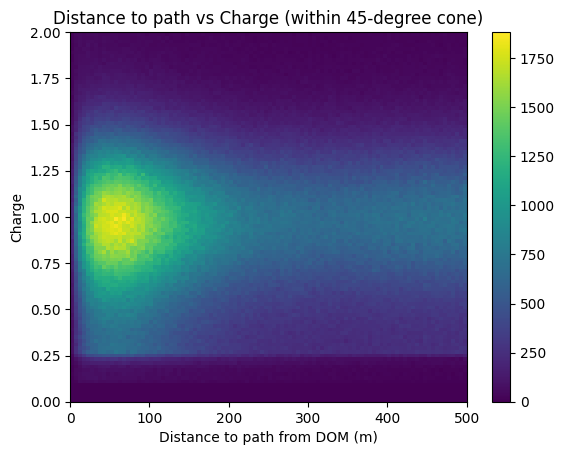

In [40]:

# Vectorized function to calculate the distance of DOMs from the particle path and apply the 45-degree cone check
def calculate_distance_to_path_with_cone(df):
    # Coordinates of DOMs
    x_dom = df['dom_x'].values
    y_dom = df['dom_y'].values
    z_dom = df['dom_z'].values
    
    # Coordinates of the particle path start and end
    x_end = df['position_x'].values  # End position directly from data
    y_end = df['position_y'].values
    z_end = df['position_z'].values
    
    # Calculate start positions directly within the function
    start_positions = df.apply(lambda row: calculate_start_position(row), axis=1)
    x_start, y_start, z_start = zip(*start_positions)
    x_start, y_start, z_start = np.array(x_start), np.array(y_start), np.array(z_start)

    # Vectors along the path and to the DOM
    path_vec = np.vstack([x_end - x_start, y_end - y_start, z_end - z_start]).T
    dom_vec = np.vstack([x_dom - x_start, y_dom - y_start, z_dom - z_start]).T
    
    # Length and unit vector along the path
    path_len = np.linalg.norm(path_vec, axis=1)  # Length of the path
    path_unit_vec = path_vec / path_len[:, np.newaxis]  # Unit vector along the path
    
    # Scalar projection to find the nearest point on the path to the DOM
    t = np.einsum('ij,ij->i', dom_vec, path_unit_vec) / path_len
    t = np.clip(t, 0, 1)  # Ensure t is between 0 and 1
    
    # Nearest points on the path
    nearest_points = path_vec * t[:, np.newaxis]
    
    # Distance vector between DOM and nearest points on the path
    distance_vec = dom_vec - nearest_points
    distance_to_path = np.linalg.norm(distance_vec, axis=1)
    
    # Calculate the angle between the path vector and the vector from the path start to the DOM
    dom_unit_vec = dom_vec / np.linalg.norm(dom_vec, axis=1)[:, np.newaxis]  # Unit vector from path start to DOM
    angles = np.arccos(np.clip(np.einsum('ij,ij->i', path_unit_vec, dom_unit_vec), -1.0, 1.0))  # Angle in radians
    
    # Filter distances by the 45-degree cone (within pi/4 radians)
    distance_to_path_cone = np.where(angles <= np.pi / 4, distance_to_path, np.nan)  # DOMs outside the cone get NaN
    
    return distance_to_path_cone

# Apply the vectorized distance function with cone check
df_merged['distance_to_path_cone'] = calculate_distance_to_path_with_cone(df_merged)

# Plot the result, excluding NaN distances
plt.hist2d(df_merged['distance_to_path_cone'], df_merged['charge'], bins=100, cmap='viridis', range=[[0, 500], [0, 2]])
plt.colorbar()
plt.xlabel('Distance to path from DOM (m)')
plt.ylabel('Charge')
plt.title('Distance to path vs Charge (within 45-degree cone)')
plt.show()


/groups/icecube/simon/Icecube/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


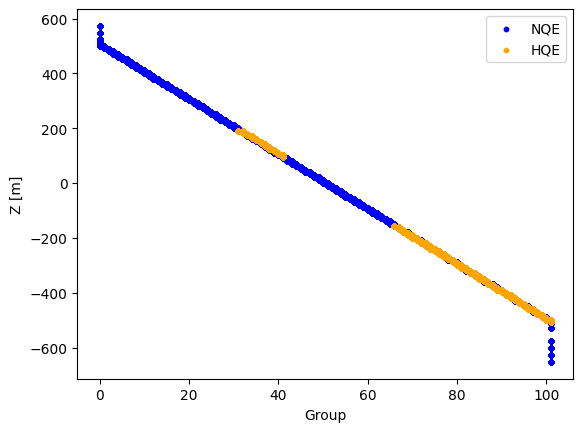

In [28]:
import matplotlib.pyplot as plt

# Define depth bins
bins = np.arange(501, -501, -10)  # Adjusted for downward depth

# Calculate depth bins and assign to new columns in df_splits  
df_splits['depth_bins'] = np.digitize(df_splits['dom_z'], bins)

# Separate data based on dom_eff
nqe_data = df_splits[df_splits['rde'] == 1.0]
hqe_data = df_splits[df_splits['rde'] == 1.35]

# Plot depth vs group index for each dom_eff
plt.scatter(nqe_data['depth_bins'], nqe_data['dom_z'], color='blue', label='NQE', s=10)
plt.scatter(hqe_data['depth_bins'], hqe_data['dom_z'], color='orange', label='HQE', s=10)

# Add labels and legend
plt.xlabel('Group')
plt.ylabel('Z [m]')
plt.legend()
plt.show()


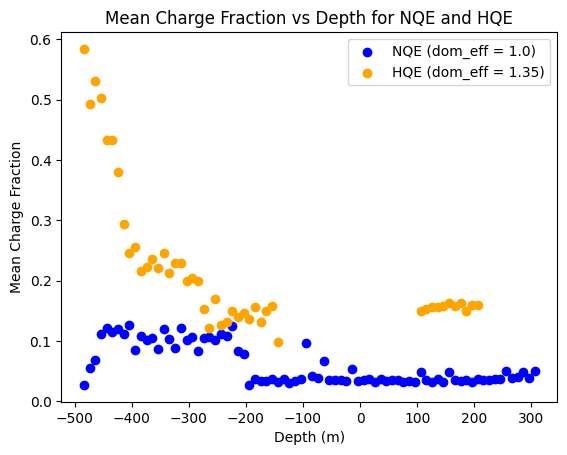

Mean Charge Fraction Ratio (HQE/NQE):
2.182480465978785


In [31]:
# Define depth bins from 300 m to -500 m with 10 m intervals
bins = np.arange(301, -501, -10)
max_depth, min_depth = 300, -500
# Filter data to keep only DOMs within the specified depth range
df_splits = df_splits[(df_splits['dom_z'] <= max_depth) & (df_splits['dom_z'] >= min_depth)]

# Assign depth bins to the filtered data
df_splits['depth_bin'] = np.digitize(df_splits['dom_z'], bins)

# Filter the data for NQE (dom_eff = 1.0) and HQE (dom_eff = 1.35)
nqe_data = df_splits[df_splits['rde'] == 1.0]
hqe_data = df_splits[df_splits['rde'] == 1.35]

# Function to calculate mean charge fraction per depth bin
def calculate_mean_charge_fraction(data):
    # Calculate total charge per event
    total_charge_per_event = data.groupby('event_no')['charge'].sum()
    
    # Calculate the charge per depth bin per event
    charge_per_depth_bin = data.groupby(['event_no', 'depth_bin'])['charge'].sum()
    
    # Calculate the fraction of charge at each depth bin relative to the total event charge
    charge_fraction_per_depth_bin = charge_per_depth_bin / total_charge_per_event
    
    # Calculate the mean charge fraction per depth bin across all events
    mean_charge_fraction_per_depth_bin = charge_fraction_per_depth_bin.groupby('depth_bin').mean()
    return mean_charge_fraction_per_depth_bin

# Calculate mean charge fraction per depth bin for NQE and HQE
mean_charge_fraction_nqe = calculate_mean_charge_fraction(nqe_data)
mean_charge_fraction_hqe = calculate_mean_charge_fraction(hqe_data)

# Adjust the depth bin centers for plotting
depth_bin_centers = bins[:-1] + 5  # Centers each bin at the midpoint (e.g., 295 for [300, 290])

# Ensure indices align with available depth_bin_centers
valid_indices_nqe = mean_charge_fraction_nqe.index[mean_charge_fraction_nqe.index <= len(depth_bin_centers)]
valid_indices_hqe = mean_charge_fraction_hqe.index[mean_charge_fraction_hqe.index <= len(depth_bin_centers)]

# Plot the mean charge fraction vs depth for NQE and HQE
plt.scatter(depth_bin_centers[valid_indices_nqe - 1], mean_charge_fraction_nqe.loc[valid_indices_nqe], color='blue', label='NQE (dom_eff = 1.0)')
plt.scatter(depth_bin_centers[valid_indices_hqe - 1], mean_charge_fraction_hqe.loc[valid_indices_hqe], color='orange', label='HQE (dom_eff = 1.35)')

plt.xlabel('Depth (m)')
plt.ylabel('Mean Charge Fraction')
plt.title('Mean Charge Fraction vs Depth for NQE and HQE')
plt.legend()
plt.show()

# Divide the mean charge fraction for HQE by the mean charge fraction for NQE
mean_charge_fraction_ratio = np.sum(mean_charge_fraction_hqe) / np.sum(mean_charge_fraction_nqe)
print(f"Mean Charge Fraction Ratio (HQE/NQE):\n{mean_charge_fraction_ratio}") 

In [11]:
def calculate_dom_distances(dom_positions, P1, P2):
    # Calculate muon direction vector and normalize it
    muon_dir = P2 - P1
    muon_dir_unit = muon_dir / np.linalg.norm(muon_dir)
    
    # Calculate the projection length of each DOM onto the muon track
    vec_P1_DOM = dom_positions - P1
    projection_lengths = np.dot(vec_P1_DOM, muon_dir_unit)
    P_DOCA = P1 + np.outer(projection_lengths, muon_dir_unit)
    
    # Calculate DOM distances to the track
    dom_distances = np.linalg.norm(dom_positions - P_DOCA, axis=1)
    return dom_distances


Monitor values for depth bins: {-500: 0.9618711577994483, -490: 0.9764332638518645, -480: 0.9848669247678769, -470: 1.004488667684548, -460: 1.0025241743895628, -450: 1.0065753415873184, -440: 0.9993960231422899, -430: 1.0005843108525099, -420: 0.9964136075734561, -410: 0.997416022887206, -400: 1.0006056721990013, -390: 0.9967249874017379, -380: 1.0019695476287915, -370: 0.9931624264501023, -360: 0.9991018760750312, -350: 1.0044288172126652, -340: 0.9981114563566668, -330: 0.999370433910405, -320: 0.9987331080336531, -310: 1.0056239711720005, -300: 0.9951189718726609, -290: 1.0009352585910696, -280: 1.0019250886648017, -270: 0.9997149326732068, -260: 1.0082761584555062, -250: 1.006007488964992, -240: 1.0057803270549088, -230: 1.0087093178828135, -220: 0.9961228712275005, -210: 0.9424661973810569, -200: 0.9545912851165583, -190: 0.938207199898265, -180: 0.9451571601209137, -170: 0.9561893115885536, -160: 0.9615001527761872, -150: 0.9608462983369828, -140: 0.9736827492713929, -130: 0.96

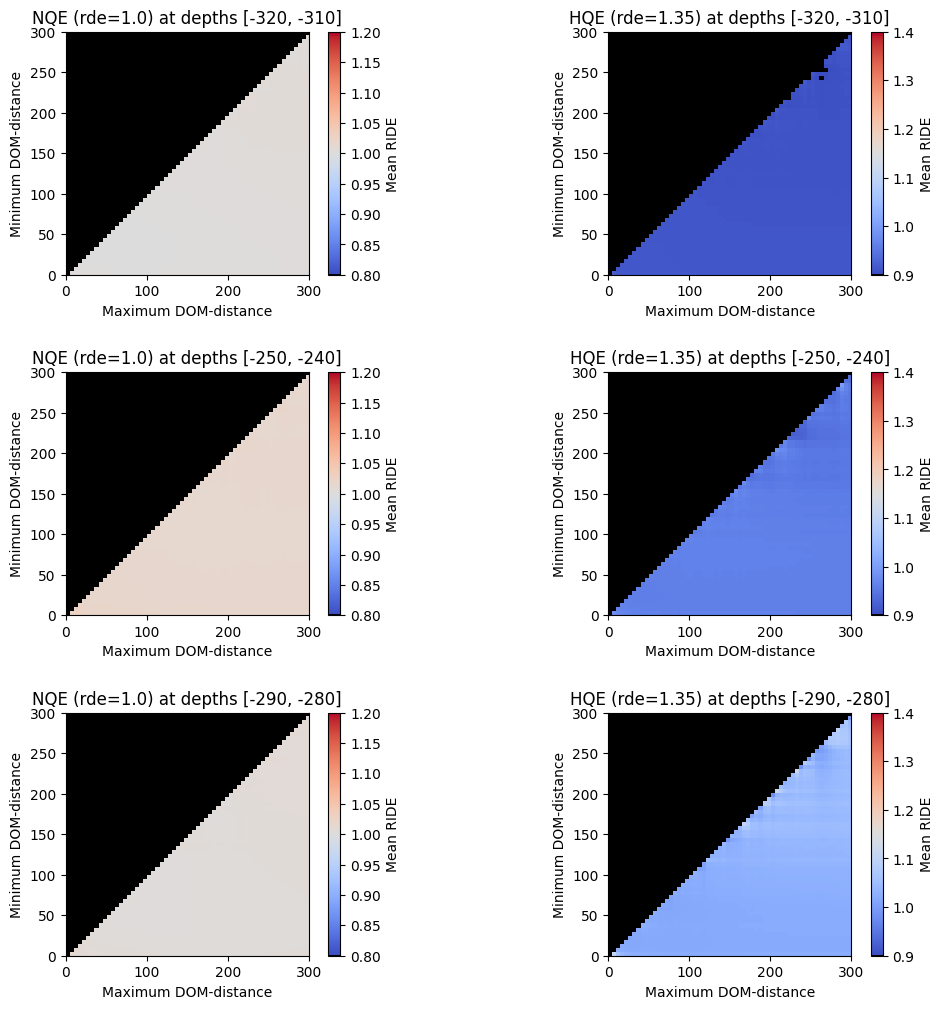

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define continuous 10-meter depth bins from -500m to 0m
all_depth_bins = np.arange(-500, 0, 10)
df_splits['depth_bin'] = pd.cut(df_splits['dom_z'], bins=all_depth_bins, labels=all_depth_bins[:-1])
muon_track_length = df_truth['track_length'].values[0]

# Initialize the 'RIDE' column with NaN values
df_splits['RIDE'] = np.nan

# Define specific depth ranges for focused plots
focus_depth_bins = [(-320, -310), (-250, -240), (-290, -280)]

# Define finer intervals for min and max distances
min_distance_values = np.arange(0, 300, 5)
max_distance_values = np.arange(0, 300, 5)

# Separate data for NQE and HQE based on 'rde' values
efficiency_groups = {
    "NQE (rde=1.0)": df_splits[df_splits['rde'] == 1.0], 
    "HQE (rde=1.35)": df_splits[df_splits['rde'] == 1.35]
}
# Pre-calculate monitor values **only** for the depth bins of interest
monitor_values = {}
grouped_nqe = efficiency_groups["NQE (rde=1.0)"].groupby('depth_bin', observed=False)

for bin, group in grouped_nqe:
    dom_indices_nqe = np.unique(group[['dom_x', 'dom_y', 'dom_z']].values, axis=0, return_inverse=True)[1]
    
    # Calculate total charge and hits per DOM
    total_charge_per_dom_nqe = np.bincount(dom_indices_nqe, weights=group['charge'].values)
    hit_count_per_dom_nqe = np.bincount(dom_indices_nqe)
    
    # Calculate average charge per hit per DOM
    avg_charge_per_hit_nqe = total_charge_per_dom_nqe / hit_count_per_dom_nqe
    
    # Store the median value for the current depth bin in the monitor_values dictionary
    if len(avg_charge_per_hit_nqe) > 0:
        monitor_values[bin] = np.median(avg_charge_per_hit_nqe)
    else:
        monitor_values[bin] = 0
            
print(f"\nMonitor values for depth bins: {monitor_values}")
# Map monitor values to all DOMs and calculate RIDE values for only the focus depth bins
dom_positions = df_splits[['dom_x', 'dom_y', 'dom_z']].values
charges = df_splits['charge'].values
depth_bins = df_splits['depth_bin'].values

unique_doms, dom_indices = np.unique(dom_positions, axis=0, return_inverse=True)
avg_charge_per_hit = np.bincount(dom_indices, weights=charges) / np.bincount(dom_indices)

# Only map monitor values for DOMs that are within the focus depth bins
monitor_per_dom = np.array([monitor_values.get(float(bin), np.nan) for bin in depth_bins[dom_indices[:len(unique_doms)]]])

valid_monitor_mask = (monitor_per_dom != 0) & (~np.isnan(monitor_per_dom))
ride_values = np.full_like(avg_charge_per_hit, np.nan)
ride_values[valid_monitor_mask] = avg_charge_per_hit[valid_monitor_mask] / monitor_per_dom[valid_monitor_mask]

df_splits['RIDE'] = ride_values[dom_indices]
efficiency_groups = {
    "NQE (rde=1.0)": df_splits[df_splits['rde'] == 1.0], 
    "HQE (rde=1.35)": df_splits[df_splits['rde'] == 1.35]
}

for focus_depth_bin in focus_depth_bins:
    depth_min, depth_max = focus_depth_bin
    sample_data = df_splits[
        (df_splits['dom_z'] >= depth_min) & 
        (df_splits['dom_z'] <= depth_max)
    ]
    #print(f"\nSample RIDE values for depth bin [{depth_min}, {depth_max}]:")
    #print(sample_data[['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE']].head(10))
    
# Define color scale limits
nqe_vmin, nqe_vmax = 0.8, 1.2
hqe_vmin, hqe_vmax = 0.9, 1.4

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through depth bins and efficiency groups to fill the plots
for depth_idx, (depth_min, depth_max) in enumerate(focus_depth_bins):
    for eff_label, data in efficiency_groups.items():
        data_filtered = data[(data['dom_z'] >= depth_min) & (data['dom_z'] <= depth_max)]  # Apply depth filter
        
        #print(f"\nDepth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, Total DOMs before filtering: {len(data)}")
        #print(f"DOMs after depth filtering: {len(data_filtered)}")
        min_distance_bins = np.arange(0, 300, 5)  # Adjust as necessary
        max_distance_bins = np.arange(0, 300, 5)
        ride_grid = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        ride_grid_counts = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        # Iterate through each event
        for event_no, event_data in data_filtered.groupby('event_no'):
            #event_data_filtered = event_data[(event_data['dom_z'] >= depth_min) & (event_data['dom_z'] <= depth_max)]
            primary_data = df_truth[df_truth['event_no'] == event_no]
            if primary_data.empty:
                continue
            
            # Start and end points of the muon track
            P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
            zenith, azimuth = primary_data['zenith'].values[0], primary_data['azimuth'].values[0]
            P2 = P1 + muon_track_length * np.array([
                np.sin(zenith) * np.cos(azimuth),
                np.sin(zenith) * np.sin(azimuth),
                np.cos(np.pi - zenith)
            ])
            
            dom_positions = event_data[['dom_x', 'dom_y', 'dom_z']].values
            ride_values = event_data['RIDE'].values
            #print(f"ride_values: {ride_values}")
            # Check DOM distances calculation
            dom_distances = calculate_dom_distances(dom_positions, P1, P2)
            #print(f"Event {event_no}: Calculated DOM Distances: {dom_distances[:5]}... (showing first 5)")


            # Iterate through all DOM distances
            for i, dom_dist in enumerate(dom_distances):
                ride_value = ride_values[i]
                #print(f"DOM {i}: distance = {dom_dist}, ride_value = {ride_value}")
                if not np.isnan(ride_value):
                    # Loop over all combinations of min_dist_bin and max_dist_bin
                    for min_dist_bin in range(len(min_distance_bins)):
                        for max_dist_bin in range(min_dist_bin, len(max_distance_bins)):  # Only fill lower triangle (min <= max)
                            
                            min_dist = min_distance_bins[min_dist_bin]
                            max_dist = max_distance_bins[max_dist_bin]

                            # Check if the DOM distance falls within the min-max bin range
                            if min_dist <= dom_dist <= max_dist:
                    
                                # Accumulate the RIDE value in the grid
                                ride_grid[min_dist_bin, max_dist_bin]+= ride_value
                                ride_grid_counts[min_dist_bin, max_dist_bin]+= 1
                                
                                #print(f"Accumulated RIDE value {ride_value} at [{min_dist}, {max_dist}], Current total in ride_grid: {ride_grid[min_dist_bin, max_dist_bin]}")
        # Normalize the accumulated RIDE values to get the mean
        #print(f"Depth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, RIDE grid counts:\n{ride_grid_counts}")
        valid_dom_contributions = np.sum(ride_grid_counts > 0)
        ride_grid = np.divide(ride_grid, ride_grid_counts, out=np.zeros_like(ride_grid), where=ride_grid_counts != 0)
        print(f"Depth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, Total contributing DOMs: {valid_dom_contributions}")
        

        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.arange(cmap.N))
        colors[0] = np.array([0, 0, 0, 1])  # Set first color (zero) to black
        custom_cmap = mcolors.ListedColormap(colors)

        # Mask zero values in the ride grid so they don't affect the color range
        ride_grid_masked = np.ma.masked_where(ride_grid == 0, ride_grid)

        # Plot with imshow, using the custom colormap
        ax = axs[depth_idx, 0 if eff_label == "NQE (rde=1.0)" else 1]
        im = ax.imshow(
            ride_grid_masked,  # No need to transpose now, we are flipping axes
            cmap=custom_cmap, origin='lower',
            vmin=(nqe_vmin if eff_label == "NQE (rde=1.0)" else hqe_vmin),
            vmax=(nqe_vmax if eff_label == "NQE (rde=1.0)" else hqe_vmax),
            extent=[0, 300, 0, 300]  # Adjust if needed for the correct range
        )
        ax.set_facecolor('black')
        ax.set_title(f"{eff_label} at depths [{depth_min}, {depth_max}]")
        ax.set_ylabel("Minimum DOM-distance")
        ax.set_xlabel("Maximum DOM-distance")
        fig.colorbar(im, ax=ax, label="Mean RIDE")

plt.show()


Sample DOM positions and calculated RIDE values:          dom_x      dom_y       dom_z    charge      RIDE
397  57.238209 -83.559966 -292.868527  1.242958  0.986827
398  57.238209 -83.559966 -292.868527  1.164914  0.986827
399  57.238209 -83.559966 -292.868527  0.641547  0.986827
400  57.238209 -83.559966 -292.868527  1.394020  0.986827
401  57.238209 -83.559966 -292.868527  0.745153  0.986827
402  57.238209 -83.559966 -292.868527  0.876993  0.986827
403  57.238209 -83.559966 -292.868527  0.719119  0.986827
404  57.238209 -83.559966 -292.868527  0.394418  0.986827
405  57.238209 -83.559966 -292.868527  1.345999  0.986827
406  57.238209 -83.559966 -292.868527  1.361285  0.986827
Depth bin [-320, -310], Efficiency group: NQE (rde=1.0), Total contributing events: 62886, Total DOMs: 295111
Depth bin [-320, -310], Efficiency group: HQE (rde=1.35), Total contributing events: 7187, Total DOMs: 15550
Depth bin [-250, -240], Efficiency group: NQE (rde=1.0), Total contributing events: 48597, Tot

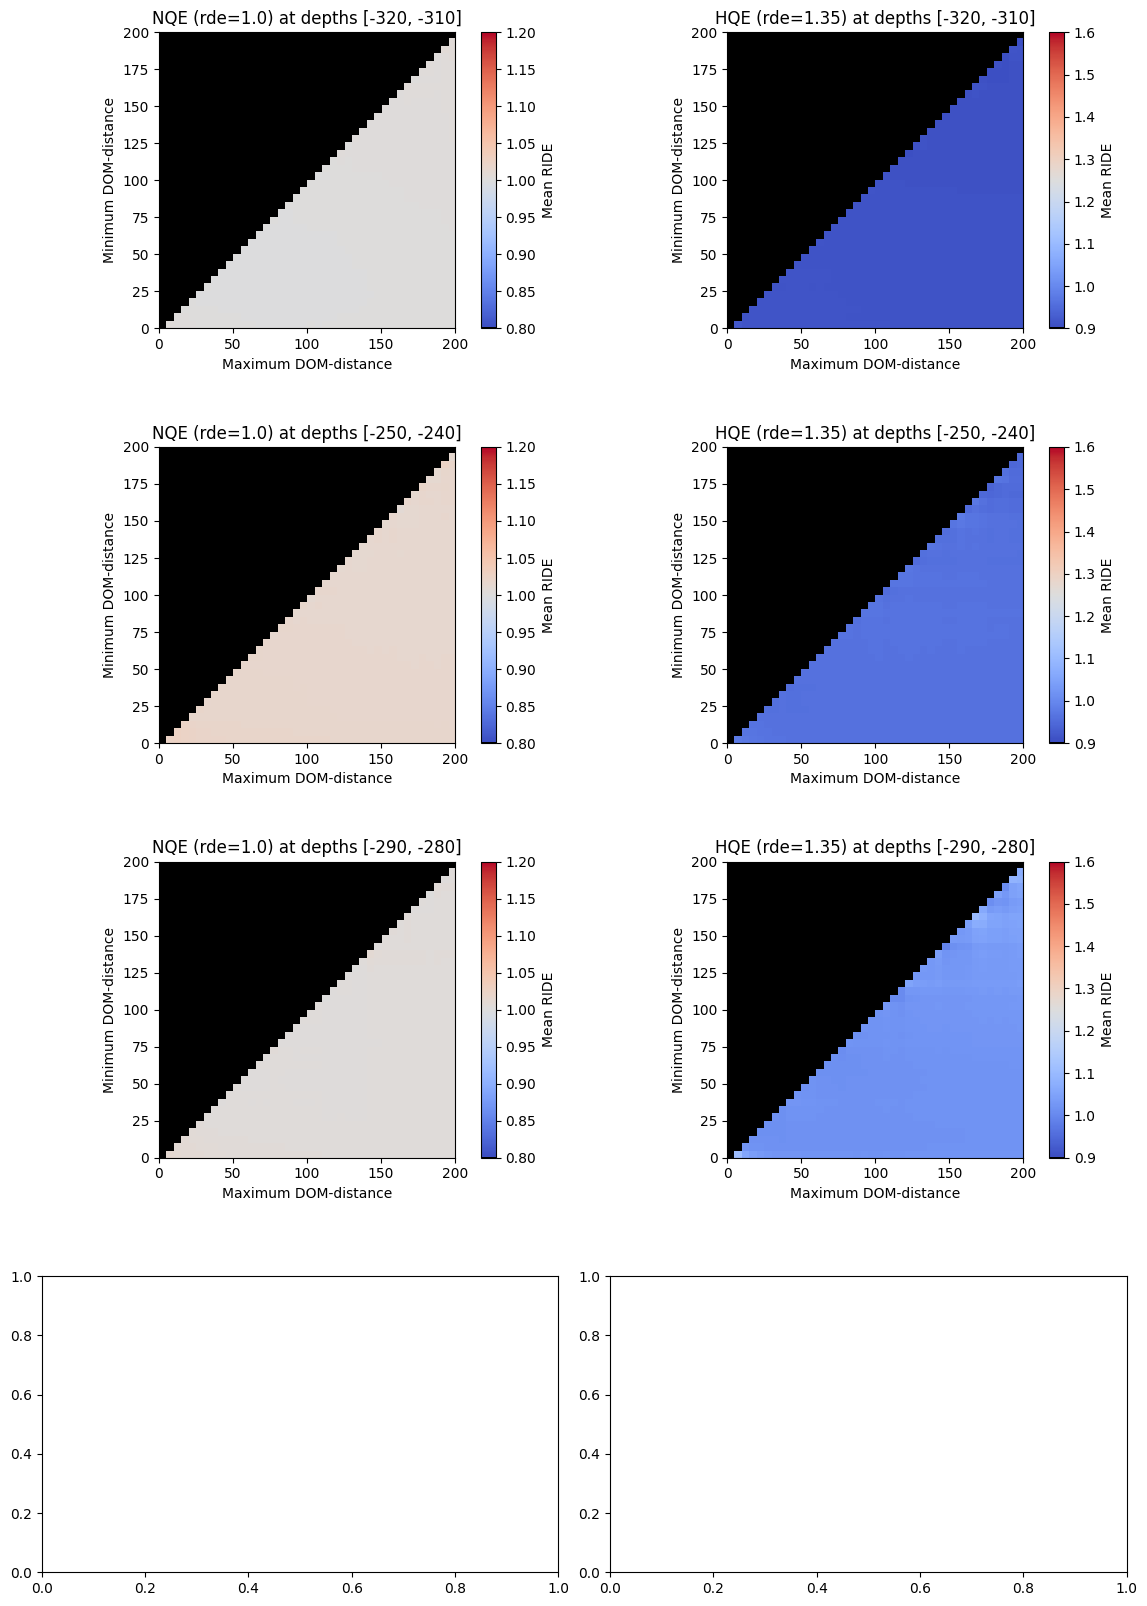

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define continuous 10-meter depth bins from -500m to 0m
all_depth_bins = np.arange(-500, 0, 10)
df_splits['depth_bin'] = pd.cut(df_splits['dom_z'], bins=all_depth_bins, labels=all_depth_bins[:-1])
muon_track_length = 200

# Initialize the 'RIDE' column with NaN values
df_splits['RIDE'] = np.nan

# Limit to a single depth bin for focused analysis
focus_depth_bins = [(-320, -310), (-250, -240), (-290, -280)]

# Define finer intervals for min and max distances
min_distance_values = np.arange(0, 200, 5)
max_distance_values = np.arange(0, 200, 5)

# Separate data for NQE and HQE based on 'rde' values
efficiency_groups = {
    "NQE (rde=1.0)": df_splits[df_splits['rde'] == 1.0], 
    "HQE (rde=1.35)": df_splits[df_splits['rde'] == 1.35]
}

# Pre-calculate monitor values **only** for the depth bins of interest
monitor_values = {}
grouped_nqe = efficiency_groups["NQE (rde=1.0)"].groupby('depth_bin', observed=False)

for bin, group in grouped_nqe:
    dom_indices_nqe = np.unique(group[['dom_x', 'dom_y', 'dom_z']].values, axis=0, return_inverse=True)[1]
    
    # Calculate total charge and hits per DOM
    total_charge_per_dom_nqe = np.bincount(dom_indices_nqe, weights=group['charge'].values)
    hit_count_per_dom_nqe = np.bincount(dom_indices_nqe)
    
    # Calculate average charge per hit per DOM
    avg_charge_per_hit_nqe = total_charge_per_dom_nqe / hit_count_per_dom_nqe
    
    # Store the median value for the current depth bin in the monitor_values dictionary
    if len(avg_charge_per_hit_nqe) > 0:
        monitor_values[bin] = np.median(avg_charge_per_hit_nqe)
    else:
        monitor_values[bin] = 0

# Map monitor values to all DOMs and calculate RIDE values for only the focus depth bins
dom_positions = df_splits[['dom_x', 'dom_y', 'dom_z']].values
charges = df_splits['charge'].values
depth_bins = df_splits['depth_bin'].values
events = df_splits['event_no'].values
unique_doms, dom_indices = np.unique(dom_positions, axis=0, return_inverse=True)
avg_charge_per_hit = np.bincount(dom_indices, weights=charges) / np.bincount(dom_indices, weights=np.ones_like(events))

# Only map monitor values for DOMs that are within the focus depth bins
monitor_per_dom = np.array([monitor_values.get(float(bin), np.nan) for bin in depth_bins[dom_indices[:len(unique_doms)]]])

valid_monitor_mask = (monitor_per_dom != 0) & (~np.isnan(monitor_per_dom))
ride_values = np.full_like(avg_charge_per_hit, np.nan)
ride_values[valid_monitor_mask] = avg_charge_per_hit[valid_monitor_mask] / monitor_per_dom[valid_monitor_mask]

df_splits['RIDE'] = ride_values[dom_indices]

efficiency_groups = {
    "NQE (rde=1.0)": df_splits[df_splits['rde'] == 1.0], 
    "HQE (rde=1.35)": df_splits[df_splits['rde'] == 1.35]
}
print(f"Sample DOM positions and calculated RIDE values: {df_splits[['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE']].head(10)}")
nqe_vmin, nqe_vmax = 0.8, 1.2
hqe_vmin, hqe_vmax = 0.9, 1.6
# Create figure for plotting
fig, axs = plt.subplots(4, 2, figsize=(14, 20))  # Adjusted for one row, two columns
fig.subplots_adjust(hspace=0.4, wspace=0.1)

# Loop through the selected single depth bin
for depth_idx, (depth_min, depth_max) in enumerate(focus_depth_bins):
    sample_data = df_splits[
        (df_splits['dom_z'] >= depth_min) & 
        (df_splits['dom_z'] <= depth_max)
    ]
    
    #print(f"\nSample RIDE values for depth bin [{depth_min}, {depth_max}]:")
    #print(sample_data[['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE']].head(10))  # Print sample RIDE data
    
    for eff_label, data in efficiency_groups.items():
        data_filtered = data[(data['dom_z'] >= depth_min) & (data['dom_z'] <= depth_max)]  # Apply depth filter
        total_events = 0
        total_doms = 0
        # Prepare ride grid and counts
        ride_grid = np.zeros((len(min_distance_values), len(max_distance_values)))
        ride_grid_counts = np.zeros((len(min_distance_values), len(max_distance_values)))

        # Iterate through each event
        for event_no, event_data in data_filtered.groupby('event_no'):
            total_events += 1
            primary_data = df_truth[df_truth['event_no'] == event_no]
            if primary_data.empty:
                continue

            # Start and end points of the muon track
            P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
            zenith, azimuth = primary_data['zenith'].values[0], primary_data['azimuth'].values[0]
            P2 = P1 + muon_track_length * np.array([
                np.sin(zenith) * np.cos(azimuth),
                np.sin(zenith) * np.sin(azimuth),
                np.cos(zenith)
            ])

            dom_positions = event_data[['dom_x', 'dom_y', 'dom_z']].values
            ride_values = event_data['RIDE'].values

            # Print DOM distance and RIDE values
            dom_distances = calculate_dom_distances(dom_positions, P1, P2)
            total_doms += len(dom_distances)
            #for i, dom_dist in enumerate(dom_distances):
            #    print(f"DOM {i}: distance = {dom_dist}, ride_value = {ride_values[i]}")
            
            # Proceed with grid logic
            for i, dom_dist in enumerate(dom_distances):
                ride_value = ride_values[i]
                if not np.isnan(ride_value):
                    # Loop over all combinations of min_dist_bin and max_dist_bin
                    for min_dist_bin in range(len(min_distance_values)):
                        for max_dist_bin in range(min_dist_bin, len(max_distance_values)):  # Only fill lower triangle (min <= max)
                            min_dist = min_distance_values[min_dist_bin]
                            max_dist = max_distance_values[max_dist_bin]

                            # Check if the DOM distance falls within the min-max bin range
                            if min_dist <= dom_dist <= max_dist:
                                tolerance = 1e-2  # small tolerance to catch near-diagonal values

                                if abs(min_dist - max_dist) < tolerance:
                                    print(f"Accumulating on the diagonal at distance {min_dist} for ride_value: {ride_value}")
                                # Accumulate the RIDE value in the grid
                                ride_grid[min_dist_bin, max_dist_bin] += ride_value
                                ride_grid_counts[min_dist_bin, max_dist_bin] += 1

        # Normalize the accumulated RIDE values to get the mean
        valid_dom_contributions = np.sum(ride_grid_counts > 0)
        ride_grid = np.divide(ride_grid, ride_grid_counts, out=np.zeros_like(ride_grid), where=ride_grid_counts != 0)
        print(f"Depth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, Total contributing events: {total_events}, Total DOMs: {total_doms}")
        
        # Setup colormap: Set zeros (no contribution) to black
        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.arange(cmap.N))
        colors[0] = np.array([0, 0, 0, 1])  # Set first color (zero) to black
        custom_cmap = mcolors.ListedColormap(colors)

        # Mask zero values in the ride grid so they don't affect the color range
        ride_grid_masked = np.ma.masked_where(ride_grid == 0, ride_grid)

        # Plot with imshow, using the custom colormap
        ax = axs[depth_idx,0 if eff_label == "NQE (rde=1.0)" else 1]
        im = ax.imshow(
            ride_grid_masked,  # No need to transpose now, we are flipping axes
            cmap=custom_cmap, origin='lower',
            vmin=(nqe_vmin if eff_label == "NQE (rde=1.0)" else hqe_vmin),
            vmax=(nqe_vmax if eff_label == "NQE (rde=1.0)" else hqe_vmax),
            extent=[0, 200, 0, 200]  # Adjust if needed for the correct range
        )
        ax.set_facecolor('black')
        ax.set_title(f"{eff_label} at depths [{depth_min}, {depth_max}]")
        ax.set_ylabel("Minimum DOM-distance")
        ax.set_xlabel("Maximum DOM-distance")
        fig.colorbar(im, ax=ax, label="Mean RIDE")

plt.show()


Sample NQE DOM positions and calculated RIDE_NQE values:
         dom_x      dom_y       dom_z    charge  RIDE_NQE
397  57.238209 -83.559966 -292.868527  1.242958       NaN
398  57.238209 -83.559966 -292.868527  1.164914       NaN
399  57.238209 -83.559966 -292.868527  0.641547       NaN
400  57.238209 -83.559966 -292.868527  1.394020       NaN
401  57.238209 -83.559966 -292.868527  0.745153       NaN
402  57.238209 -83.559966 -292.868527  0.876993       NaN
403  57.238209 -83.559966 -292.868527  0.719119       NaN
404  57.238209 -83.559966 -292.868527  0.394418       NaN
405  57.238209 -83.559966 -292.868527  1.345999       NaN
406  57.238209 -83.559966 -292.868527  1.361285       NaN
Sample HQE DOM positions and calculated RIDE_HQE values:
       dom_x   dom_y   dom_z    charge  RIDE_HQE
652   -10.97    6.72 -241.10  1.004557       NaN
1742   57.20 -105.52  125.95  1.042844       NaN
1743   -9.68  -79.50  100.90  0.780934       NaN
1744   -9.68  -79.50 -170.43  0.264861  0.983402
174

KeyboardInterrupt: 

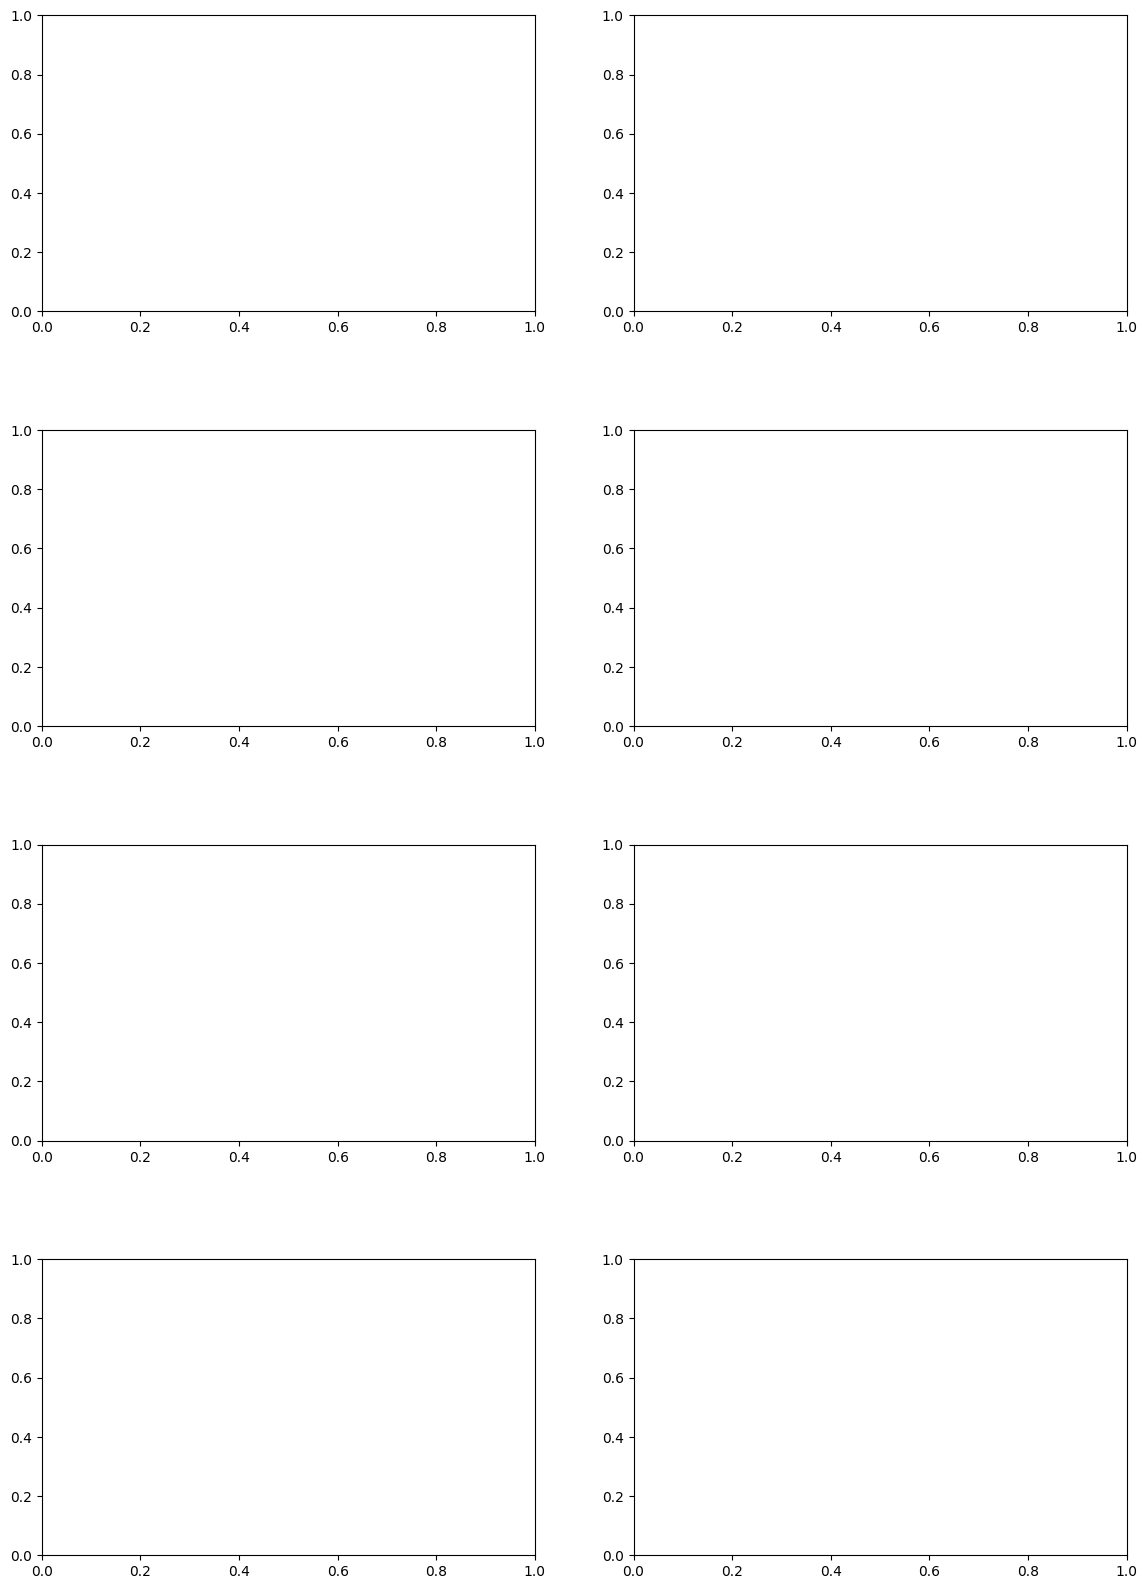

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df_truth = df_truth[df_truth['stopped_muon']==1]
df_truth = df_truth[df_truth['SubEventID']==0]
# Apply the same mask to the split data
df_splits = df_splits[df_splits['event_no'].isin(df_truth['event_no'])]
# Define continuous 10-meter depth bins from -500m to 0m
all_depth_bins = np.arange(-500, 0, 10)
df_splits['depth_bin'] = pd.cut(df_splits['dom_z'], bins=all_depth_bins, labels=all_depth_bins[:-1])

# Initialize columns for 'RIDE_NQE' and 'RIDE_HQE' with NaN values
df_splits['RIDE_NQE'] = np.nan
df_splits['RIDE_HQE'] = np.nan

# Define specific depth ranges for focused plots
focus_depth_bins = [(-320, -310), (-250, -240), (-200, -190)]

# Separate data for NQE and HQE based on 'rde' values
nqe_group = df_splits[df_splits['rde'] == 1.0]  # Only DOMs with rde = 1.0 for NQE
hqe_group = df_splits[df_splits['rde'] == 1.35]  # Only DOMs with rde = 1.35 for HQE

# Step 1: Calculate the monitor value (median NQE charge per hit) for each depth bin
monitor_values = {}
grouped_nqe = nqe_group.groupby('depth_bin', observed=False)

for bin, group in grouped_nqe:
    dom_indices_nqe = np.unique(group[['dom_x', 'dom_y', 'dom_z']].values, axis=0, return_inverse=True)[1]
    total_charge_per_dom_nqe = np.bincount(dom_indices_nqe, weights=group['charge'].values)
    hit_count_per_dom_nqe = np.bincount(dom_indices_nqe, weights=np.ones_like(group['event_no'].values))
    
    # Calculate average charge per hit for NQE DOMs
    avg_charge_per_hit_nqe = total_charge_per_dom_nqe / hit_count_per_dom_nqe
    
    # Store the median value for this depth bin in the monitor_values dictionary
    if len(avg_charge_per_hit_nqe) > 0:
        monitor_values[bin] = np.median(avg_charge_per_hit_nqe)

    else:
        monitor_values[bin] = 0

# Step 2: Calculate total charge and number of events for each DOM for both NQE and HQE
dom_positions_nqe = nqe_group[['dom_x', 'dom_y', 'dom_z']].values
dom_positions_hqe = hqe_group[['dom_x', 'dom_y', 'dom_z']].values

charges_nqe = nqe_group['charge'].values
charges_hqe = hqe_group['charge'].values

events_nqe = nqe_group['event_no'].values
events_hqe = hqe_group['event_no'].values

depth_bins_nqe = nqe_group['depth_bin'].values
depth_bins_hqe = hqe_group['depth_bin'].values

# Unique DOMs for NQE and HQE
unique_doms_nqe, dom_indices_nqe = np.unique(dom_positions_nqe, axis=0, return_inverse=True)
unique_doms_hqe, dom_indices_hqe = np.unique(dom_positions_hqe, axis=0, return_inverse=True)

# Total charge for NQE DOMs (sum over all events the DOM is part of)
total_charge_per_dom_nqe = np.bincount(dom_indices_nqe, weights=charges_nqe)

# Count the number of unique events each DOM participated in (this is now the number of events, not hits)
event_count_per_dom_nqe = np.bincount(dom_indices_nqe, weights=np.ones_like(events_nqe))

# Average charge per event for each NQE DOM
avg_charge_per_event_nqe = total_charge_per_dom_nqe / event_count_per_dom_nqe

# Step 3: Calculate the monitor value (median NQE average charge per event) for each depth bin
monitor_per_dom_nqe = np.array([monitor_values.get(float(bin), np.nan) for bin in depth_bins_nqe[dom_indices_nqe[:len(unique_doms_nqe)]]])

# Step 4: Calculate RIDE for NQE DOMs using the monitor value
valid_monitor_mask_nqe = (monitor_per_dom_nqe != 0) & (~np.isnan(monitor_per_dom_nqe))
ride_nqe_values = np.full_like(avg_charge_per_event_nqe, np.nan)
ride_nqe_values[valid_monitor_mask_nqe] = avg_charge_per_event_nqe[valid_monitor_mask_nqe] / monitor_per_dom_nqe[valid_monitor_mask_nqe]

df_splits.loc[nqe_group.index, 'RIDE_NQE'] = ride_nqe_values[dom_indices_nqe]

# Repeat the process for HQE DOMs (using the monitor from NQE DOMs)

# Total charge for HQE DOMs
total_charge_per_dom_hqe = np.bincount(dom_indices_hqe, weights=charges_hqe)

# Count the number of unique events each HQE DOM participated in
event_count_per_dom_hqe = np.bincount(dom_indices_hqe, weights=np.ones_like(events_hqe))

# Average charge per event for each HQE DOM
avg_charge_per_event_hqe = total_charge_per_dom_hqe / event_count_per_dom_hqe

# Use the same NQE monitor values
monitor_per_dom_hqe = np.array([monitor_values.get(float(bin), np.nan) for bin in depth_bins_hqe[dom_indices_hqe[:len(unique_doms_hqe)]]])

valid_monitor_mask_hqe = (monitor_per_dom_hqe != 0) & (~np.isnan(monitor_per_dom_hqe))
ride_hqe_values = np.full_like(avg_charge_per_event_hqe, np.nan)
ride_hqe_values[valid_monitor_mask_hqe] = avg_charge_per_event_hqe[valid_monitor_mask_hqe] / monitor_per_dom_hqe[valid_monitor_mask_hqe]

df_splits.loc[hqe_group.index, 'RIDE_HQE'] = ride_hqe_values[dom_indices_hqe]

print(f"Sample NQE DOM positions and calculated RIDE_NQE values:\n{df_splits[df_splits['rde'] == 1.0][['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE_NQE']].head(10)}")
print(f"Sample HQE DOM positions and calculated RIDE_HQE values:\n{df_splits[df_splits['rde'] == 1.35][['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE_HQE']].head(10)}")

# Now the plotting part:
# Define color scale limits
nqe_vmin, nqe_vmax = 0.8, 1.2
hqe_vmin, hqe_vmax = 0.8, 1.2
min_distance_bins = np.arange(0, 200, 5)
max_distance_bins = np.arange(0, 200, 5)
fig, axs = plt.subplots(4, 2, figsize=(14, 20)) 
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for depth_idx, (depth_min, depth_max) in enumerate(focus_depth_bins):
    #print(f"\nDepth bin [{depth_min}, {depth_max}]")
    for eff_label, data in {"NQE": df_splits[df_splits['RIDE_NQE'].notnull()],
                            "HQE": df_splits[df_splits['RIDE_HQE'].notnull()]}.items():
        data_filtered = data[(data['dom_z'] >= depth_min) & (data['dom_z'] <= depth_max)]
        
        ride_grid = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        ride_grid_counts = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        total_events = 0
        total_doms = 0
        for event_no, event_data in data_filtered.groupby('event_no'):
            primary_data = df_truth[df_truth['event_no'] == event_no]
            total_events += 1
            if primary_data.empty:
                continue
            P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
            zenith, azimuth, muon_track_length = primary_data['zenith'].values[0], primary_data['azimuth'].values[0], primary_data['track_length'].values[0]
            P2 = P1 + muon_track_length * np.array([
                np.sin(zenith) * np.cos(azimuth),
                np.sin(zenith) * np.sin(azimuth),
                np.cos(zenith)
            ])
            dom_positions = data_filtered[['dom_x', 'dom_y', 'dom_z']].values
            charges = data_filtered['charge'].values
            ride_values = data_filtered['RIDE_NQE'].values if eff_label == "NQE" else data_filtered['RIDE_HQE'].values
            
            dom_distances = calculate_dom_distances(dom_positions, P1, P2)
            total_doms += len(dom_distances)
            within_distance_mask = dom_distances <= 200
            dom_distances = dom_distances[within_distance_mask]
            ride_values = ride_values[within_distance_mask]
            charges = charges[within_distance_mask]
            
            #print(f"Event {event_no}:Number of DOMs: {len(dom_distances)}")
            for i, dom_dist in enumerate(dom_distances):
                ride_value = ride_values[i]
                if not np.isnan(ride_value):
                    # Populate lower triangular region (min_dist_bin <= max_dist_bin)
                    for min_dist_bin in range(len(min_distance_bins)):
                        for max_dist_bin in range(min_dist_bin, len(max_distance_bins)):
                            min_dist = min_distance_bins[min_dist_bin]
                            max_dist = max_distance_bins[max_dist_bin]
                            if min_dist <= dom_dist <= max_dist:
                                ride_grid[min_dist_bin, max_dist_bin] += ride_value
                                ride_grid_counts[min_dist_bin, max_dist_bin] += 1

        # Normalize the RIDE grid by the number of contributions
        ride_grid = np.divide(ride_grid, ride_grid_counts, out=np.zeros_like(ride_grid), where=ride_grid_counts != 0)
        print(f"Depth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, Total contributing events: {total_events}, Total DOMs: {total_doms}")
        # Custom colormap to show zeros as black
        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.arange(cmap.N))
        colors[0] = np.array([0, 0, 0, 1])  # Set first color (zero) to black
        custom_cmap = mcolors.ListedColormap(colors)

        # Mask zero values
        ride_grid_masked = np.ma.masked_where(ride_grid == 0, ride_grid)

        # Plot with imshow
        ax = axs[depth_idx, 0 if eff_label == "NQE" else 1]
        im = ax.imshow(
            ride_grid_masked,
            cmap=custom_cmap, origin='lower',
            vmin=(nqe_vmin if eff_label == "NQE" else hqe_vmin),
            vmax=(nqe_vmax if eff_label == "NQE" else hqe_vmax),
            extent=[0, 200, 0, 200]
        )
        ax.set_facecolor('black')
        ax.set_title(f"{eff_label} at depths [{depth_min}, {depth_max}]")
        ax.set_ylabel("Minimum DOM-distance")
        ax.set_xlabel("Maximum DOM-distance")
        fig.colorbar(im, ax=ax, label="Mean RIDE")

plt.show()


In [ ]:
import numpy as np
import pandas as pd

#Filtert truth data for SubEvent == 0 and for stopped_muon = 1
df_truth = df_truth[df_truth['stopped_muon']==1]
df_truth = df_truth[df_truth['SubEventID']==0]
# Apply the same mask to the split data
df_splits = df_splits[df_splits['event_no'].isin(df_truth['event_no'])]

# Define continuous 10-meter depth bins from -500m to 0m
all_depth_bins = np.arange(-500, 0, 10)
df_splits['depth_bin'] = pd.cut(df_splits['dom_z'], bins=all_depth_bins, labels=all_depth_bins[:-1])

# Initialize columns for 'RIDE_NQE' and 'RIDE_HQE' with NaN values
df_splits['RIDE_NQE'] = np.nan
df_splits['RIDE_HQE'] = np.nan

# Step 1: Calculate the monitor value (median charge per hit) for each depth bin in the NQE group
monitor_values = {}
grouped_nqe = df_splits[df_splits['rde'] == 1.0].groupby('depth_bin')

for bin, group in grouped_nqe:
    dom_positions = group[['dom_x', 'dom_y', 'dom_z']].values
    charges = group['charge'].values
    dom_indices, inverse = np.unique(dom_positions, axis=0, return_inverse=True)
    
    # Total charge per DOM and number of hits per DOM
    total_charge_per_dom = np.bincount(inverse, weights=charges)
    hit_count_per_dom = np.bincount(inverse)

    # Average charge per hit per DOM
    avg_charge_per_hit = total_charge_per_dom / hit_count_per_dom

    # Monitor value is the median of the average charge per hit within this depth bin
    monitor_values[bin] = np.median(avg_charge_per_hit) if len(avg_charge_per_hit) > 0 else 1

# Step 2: Calculate the numerator (total charge per DOM divided by hit count) for NQE and HQE groups
ride_nqe_dict = {}
ride_hqe_dict = {}

for dom_id, group in df_splits.groupby(['dom_x', 'dom_y', 'dom_z']):
    charges = group['charge'].values
    rde_value = group['rde'].iloc[0]
    depth_bin = group['depth_bin'].iloc[0]
    
    # Total charge across all events for the DOM and number of hits (non-zero charges)
    total_charge = charges.sum()
    hit_count = (charges > 0).sum()
    
    if hit_count > 0:
        # Calculate the average charge per hit (numerator)
        avg_charge_per_hit_dom = total_charge / hit_count
        
        # Use monitor value for normalization based on depth bin
        monitor_value = monitor_values.get(depth_bin, 1)

        # Calculate RIDE
        ride_value = avg_charge_per_hit_dom / monitor_value
        
        # Store in respective dictionary based on NQE or HQE
        if rde_value == 1.0:
            ride_nqe_dict[dom_id] = ride_value
        elif rde_value == 1.35:
            ride_hqe_dict[dom_id] = ride_value

# Step 3: Map calculated RIDE values back to df_splits

# Map RIDE_NQE values
ride_nqe_series = pd.Series(ride_nqe_dict)
df_splits['RIDE_NQE'] = df_splits.apply(
    lambda row: ride_nqe_series.get((row['dom_x'], row['dom_y'], row['dom_z']), np.nan), axis=1
)

# Map RIDE_HQE values
ride_hqe_series = pd.Series(ride_hqe_dict)
df_splits['RIDE_HQE'] = df_splits.apply(
    lambda row: ride_hqe_series.get((row['dom_x'], row['dom_y'], row['dom_z']), np.nan), axis=1
)

# Now the plotting part:
# Define color scale limits
nqe_vmin, nqe_vmax = 0.8, 1.2
hqe_vmin, hqe_vmax = 0.8, 1.2
min_distance_bins = np.arange(0, 200, 5)
max_distance_bins = np.arange(0, 200, 5)
fig, axs = plt.subplots(4, 2, figsize=(14, 20)) 
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for depth_idx, (depth_min, depth_max) in enumerate(focus_depth_bins):
    for eff_label, data in {"NQE": df_splits[df_splits['RIDE_NQE'].notnull()],
                            "HQE": df_splits[df_splits['RIDE_HQE'].notnull()]}.items():
        data_filtered = data[(data['dom_z'] >= depth_min) & (data['dom_z'] <= depth_max)]
        
        ride_grid = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        ride_grid_counts = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        total_events = 0
        total_doms = 0
        for event_no, event_data in data_filtered.groupby('event_no'):
            primary_data = df_truth[df_truth['event_no'] == event_no]  
            total_events += 1
            if primary_data.empty:
                continue
            P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
            zenith, azimuth, muon_track_length = primary_data['zenith'].values[0], primary_data['azimuth'].values[0], primary_data['track_length'].values[0]
            P2 = P1 + muon_track_length * np.array([
                np.sin(zenith) * np.cos(azimuth),
                np.sin(zenith) * np.sin(azimuth),
                np.cos(zenith)
            ])
            dom_positions = data_filtered[['dom_x', 'dom_y', 'dom_z']].values
            charges = data_filtered['charge'].values
            ride_values = data_filtered['RIDE_NQE'].values if eff_label == "NQE" else data_filtered['RIDE_HQE'].values
            
            dom_distances = calculate_dom_distances(dom_positions, P1, P2)
            total_doms += len(dom_distances)
            within_distance_mask = dom_distances <= 200
            dom_distances = dom_distances[within_distance_mask]
            ride_values = ride_values[within_distance_mask]
            charges = charges[within_distance_mask]
            
            # Populate the RIDE grid
            for i, dom_dist in enumerate(dom_distances):
                ride_value = ride_values[i]
                if not np.isnan(ride_value):
                    # Populate lower triangular region (min_dist_bin <= max_dist_bin)
                    for min_dist_bin in range(len(min_distance_bins)):
                        for max_dist_bin in range(min_dist_bin, len(max_distance_bins)):
                            min_dist = min_distance_bins[min_dist_bin]
                            max_dist = max_distance_bins[max_dist_bin]
                            if min_dist <= dom_dist <= max_dist:
                                ride_grid[min_dist_bin, max_dist_bin] += ride_value
                                ride_grid_counts[min_dist_bin, max_dist_bin] += 1

        # Normalize the RIDE grid by the number of contributions
        ride_grid = np.divide(ride_grid, ride_grid_counts, out=np.zeros_like(ride_grid), where=ride_grid_counts != 0)
        print(f"Depth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, Total contributing events: {total_events}, Total DOMs: {total_doms}")
        # Custom colormap to show zeros as black
        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.arange(cmap.N))
        colors[0] = np.array([0, 0, 0, 1])  # Set first color (zero) to black
        custom_cmap = mcolors.ListedColormap(colors)

        # Mask zero values
        ride_grid_masked = np.ma.masked_where(ride_grid == 0, ride_grid)

        # Plot with imshow
        ax = axs[depth_idx, 0 if eff_label == "NQE" else 1]
        im = ax.imshow(
            ride_grid_masked,
            cmap=custom_cmap, origin='lower',
            vmin=(nqe_vmin if eff_label == "NQE" else hqe_vmin),
            vmax=(nqe_vmax if eff_label == "NQE" else hqe_vmax),
            extent=[0, 200, 0, 200]
        )
        ax.set_facecolor('black')
        ax.set_title(f"{eff_label} at depths [{depth_min}, {depth_max}]")
        ax.set_ylabel("Minimum DOM-distance")
        ax.set_xlabel("Maximum DOM-distance")
        fig.colorbar(im, ax=ax, label="Mean RIDE")

plt.show()


/tmp/ipykernel_3301017/3775361049.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_nqe = df_splits[df_splits['rde'] == 1.0].groupby('depth_bin')


KeyboardInterrupt: 

KeyboardInterrupt: 

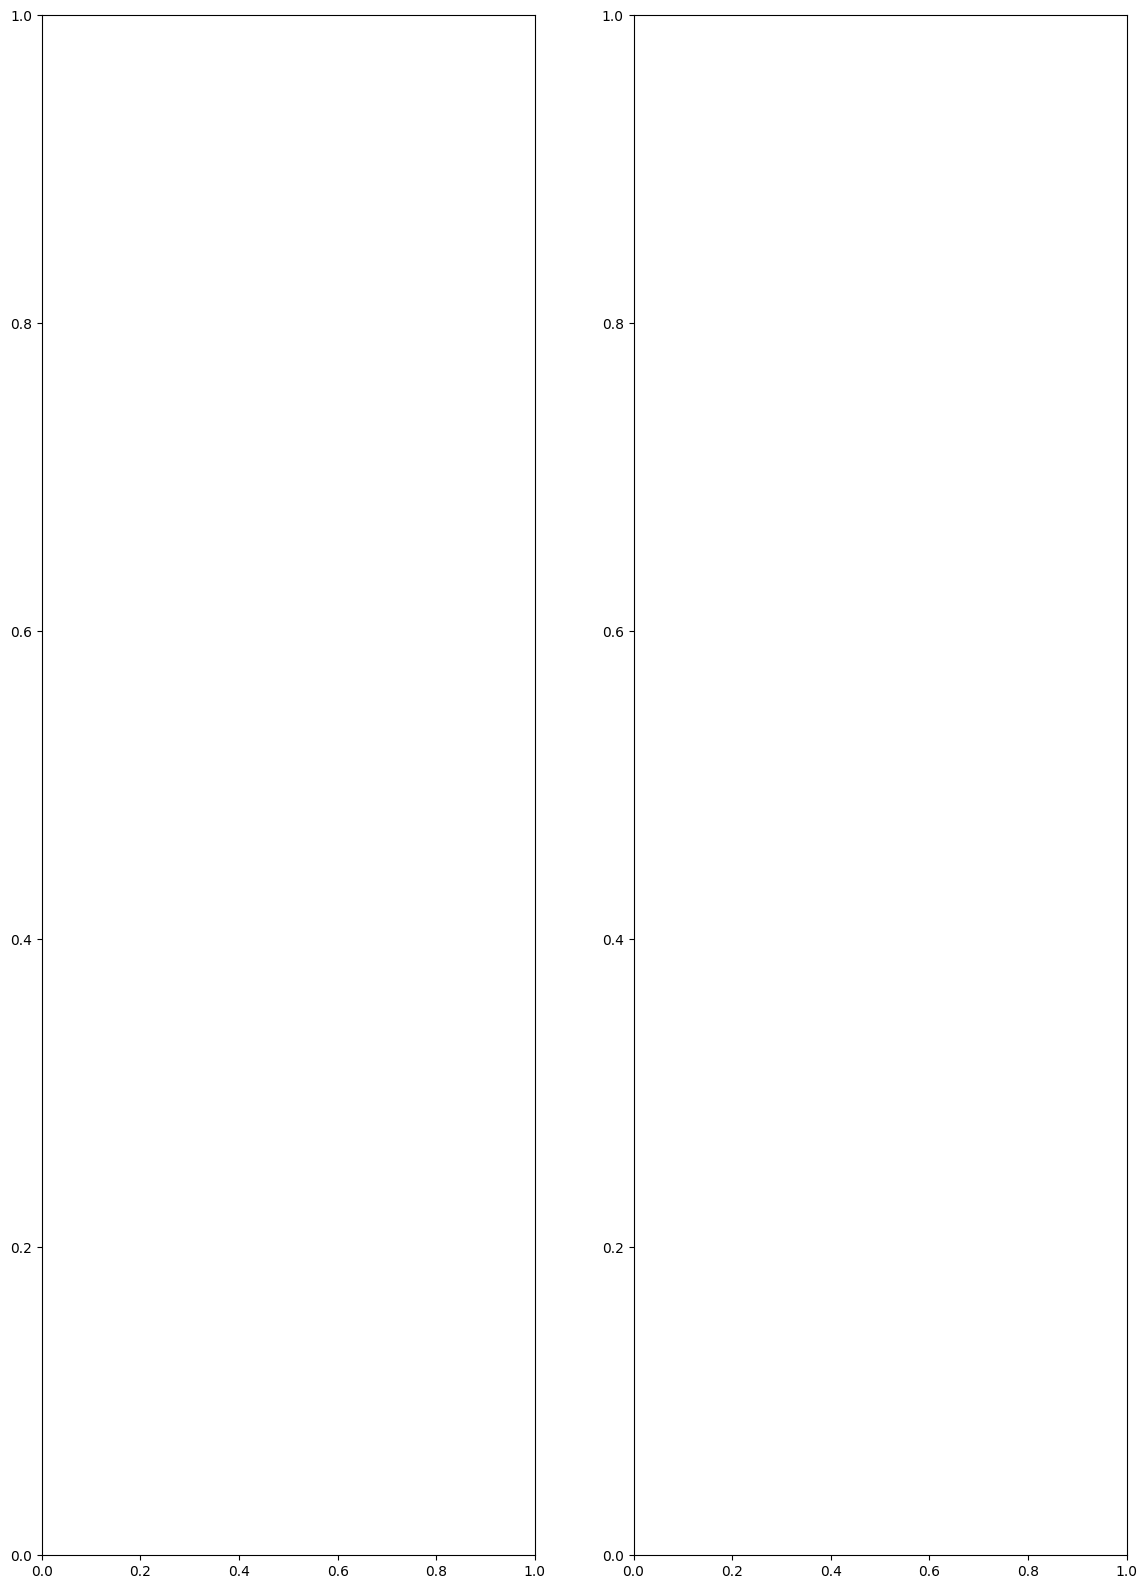

In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Filter the dataframe based on conditions
df_truth = df_truth[(df_truth['stopped_muon'] == 1) & (df_truth['SubEventID'] == 0)]
df_splits = df_splits[df_splits['event_no'].isin(df_truth['event_no'])]

# Define depth bins and labels
all_depth_bins = np.arange(-500, 0, 10)
df_splits['depth_bin'] = pd.cut(df_splits['dom_z'], bins=all_depth_bins, labels=all_depth_bins[:-1])

# Initialize columns for 'RIDE_NQE' and 'RIDE_HQE'
df_splits[['RIDE_NQE', 'RIDE_HQE']] = np.nan

# Separate NQE and HQE groups based on 'rde' values
nqe_group = df_splits[df_splits['rde'] == 1.0]
hqe_group = df_splits[df_splits['rde'] == 1.35]

# Use PyTorch tensors and move to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Calculate median NQE charge per hit for each depth bin
monitor_values = {}
for bin, group in nqe_group.groupby('depth_bin', observed=False):
    dom_positions = torch.tensor(group[['dom_x', 'dom_y', 'dom_z']].values, device=device)
    dom_indices = torch.unique(dom_positions, dim=0, return_inverse=True)[1]
    charges = torch.tensor(group['charge'].values, device=device, dtype=torch.float32)
    
    total_charge = torch.bincount(dom_indices, weights=charges)
    hit_count = torch.bincount(dom_indices)
    
    avg_charge_per_hit = total_charge / hit_count
    monitor_values[bin] = avg_charge_per_hit.median().item() if avg_charge_per_hit.numel() > 0 else 0

# Function to calculate RIDE values using PyTorch
def calculate_ride(df, monitor_vals, device):
    dom_positions = torch.tensor(df[['dom_x', 'dom_y', 'dom_z']].values, device=device)
    charges = torch.tensor(df['charge'].values, device=device, dtype=torch.float32)
    events = torch.tensor(df['event_no'].values, device=device)
    
    # Find unique DOM positions and their indices
    unique_doms, dom_indices = torch.unique(dom_positions, dim=0, return_inverse=True)
    total_charge = torch.bincount(dom_indices, weights=charges)
    event_count = torch.bincount(dom_indices)
    avg_charge_per_event = total_charge / event_count
    
    # Create an array for all monitor values, matching the length of `dom_indices`
    monitor_values_tensor = torch.tensor([monitor_vals.get(float(bin), np.nan) for bin in df['depth_bin']], device=device)
    monitor_values_expanded = monitor_values_tensor[dom_indices]
    
    # Calculate RIDE for valid entries
    valid_mask = (monitor_values_expanded != 0) & (~torch.isnan(monitor_values_expanded))
    ride_values = torch.full((len(df),), torch.nan, device=device)
    ride_values[valid_mask] = avg_charge_per_event[dom_indices][valid_mask] / monitor_values_expanded[valid_mask]
    
    # Return as a numpy array of the same length as `df`
    return ride_values.cpu().numpy()

# Calculate RIDE values for NQE and HQE
df_splits.loc[nqe_group.index, 'RIDE_NQE'] = calculate_ride(nqe_group, monitor_values, device)
df_splits.loc[hqe_group.index, 'RIDE_HQE'] = calculate_ride(hqe_group, monitor_values, device)

# Plotting with PyTorch for GPU acceleration is not common, so we use standard Matplotlib for visualization
focus_depth_bins = [(-320, -310)]#, (-250, -240), (-200, -190)]
min_distance_bins = np.arange(0, 200, 5)
max_distance_bins = np.arange(0, 200, 5)

fig, axs = plt.subplots(len(focus_depth_bins), 2, figsize=(14, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for depth_idx, (depth_min, depth_max) in enumerate(focus_depth_bins):
    for eff_label, data in {"NQE": df_splits[df_splits['RIDE_NQE'].notnull()],
                            "HQE": df_splits[df_splits['RIDE_HQE'].notnull()]}.items():
        data_filtered = data[(data['dom_z'] >= depth_min) & (data['dom_z'] <= depth_max)]

        # Pre-allocate arrays for ride_grid and counts
        ride_grid = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        ride_grid_counts = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        
        # Calculate DOM distances and RIDE values
        for event_no, event_data in data_filtered.groupby('event_no'):
            primary_data = df_truth[df_truth['event_no'] == event_no]
            if primary_data.empty:
                continue
            
            P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
            zenith, azimuth, track_length = primary_data[['zenith', 'azimuth', 'track_length']].values[0]
            P2 = P1 + track_length * np.array([np.sin(zenith) * np.cos(azimuth), np.sin(zenith) * np.sin(azimuth), np.cos(zenith)])
            
            dom_positions = torch.tensor(data_filtered[['dom_x', 'dom_y', 'dom_z']].values, device=device)
            dom_positions = dom_positions.to(dtype=torch.float32)  
            P1 = torch.tensor(P1, device=device, dtype=torch.float32)
            P2 = torch.tensor(P2, device=device, dtype=torch.float32)
            
            direction = (P2 - P1).unsqueeze(0).to(dtype=torch.float32)  # Makes direction have shape [1, 3]
            dom_distances = torch.norm(torch.cross(direction, dom_positions - P1, dim=1) / torch.norm(direction, dim=1), dim=1).cpu().numpy()
            dom_distances = dom_distances[dom_distances <= 200]
            
            ride_values = data_filtered['RIDE_NQE' if eff_label == "NQE" else 'RIDE_HQE'].values[:len(dom_distances)]
            
            for min_idx, min_dist in enumerate(min_distance_bins):
                max_dist = max_distance_bins[min_idx:]

                # Expand dom_distances to shape [234, 1] and max_dist to shape [1, 40] for broadcasting
                expanded_dom_distances = dom_distances[:, None]
                mask = (expanded_dom_distances >= min_dist) & (expanded_dom_distances <= max_dist)

                # Update ride_grid and ride_grid_counts with the broadcasted mask
                ride_values_expanded = ride_values[:, None]  # Make ride_values compatible with mask
                ride_grid[min_idx, min_idx:] += np.where(mask, ride_values_expanded, 0).sum(axis=0)
                ride_grid_counts[min_idx, min_idx:] += mask.sum(axis=0)
                
        ride_grid = np.divide(ride_grid, ride_grid_counts, out=np.zeros_like(ride_grid), where=ride_grid_counts != 0)
        
        # Plot
        ax = axs[depth_idx, 0 if eff_label == "NQE" else 1]
        cmap = mcolors.ListedColormap(['black'] + [plt.get_cmap('coolwarm')(i) for i in range(1, 256)])
        im = ax.imshow(np.ma.masked_where(ride_grid == 0, ride_grid), cmap=cmap, origin='lower', extent=[0, 200, 0, 200], vmin=0.8, vmax=1.2)
        ax.set_title(f"{eff_label} at depths [{depth_min}, {depth_max}]")
        ax.set_xlabel("Max DOM Distance")
        ax.set_ylabel("Min DOM Distance")
        fig.colorbar(im, ax=ax, label="Mean RIDE")

plt.show()


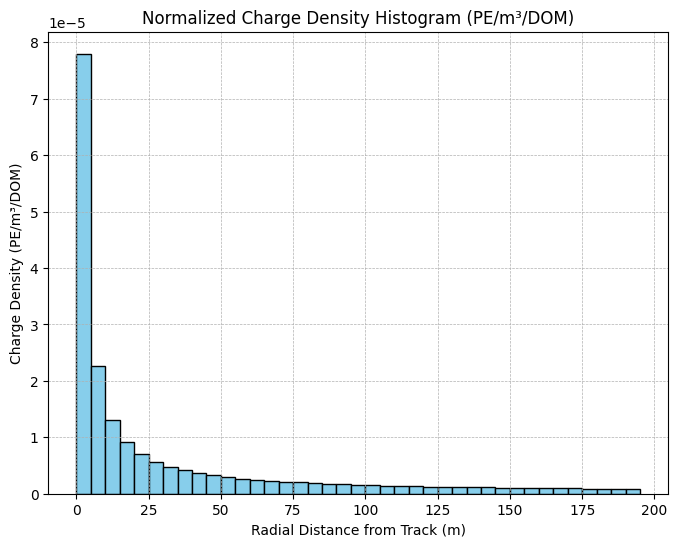

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_radial_distance(dom_positions, P1, P2):
    # Track vector and normalized direction
    muon_dir = P2 - P1
    muon_dir_unit = muon_dir / np.linalg.norm(muon_dir)
    
    # Projection length from P1 to the perpendicular point on track
    vec_P1_DOM = dom_positions - P1
    projection_lengths = np.dot(vec_P1_DOM, muon_dir_unit)
    P_closest = P1 + np.outer(projection_lengths, muon_dir_unit)  # Closest point on the track
    
    # Calculate radial distances
    radial_distances = np.linalg.norm(dom_positions - P_closest, axis=1)
    return radial_distances

# Define bins for radial distances (in meters)
radial_bins = np.arange(0, 200, 5)
charge_density = np.zeros(len(radial_bins) - 1)
dom_counts = np.zeros(len(radial_bins) - 1)  # To count DOMs per radial bin

# Loop through events and accumulate charge density
for event_no, event_data in df_splits.groupby('event_no'):
    primary_data = df_truth[df_truth['event_no'] == event_no]
    if primary_data.empty:
        continue
    
    P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
    zenith, azimuth, track_length = primary_data[['zenith', 'azimuth', 'track_length']].values[0]
    P2 = P1 + track_length * np.array([np.sin(zenith) * np.cos(azimuth), np.sin(zenith) * np.sin(azimuth), np.cos(np.pi - zenith)])

    # Get DOM positions and charges
    dom_positions = event_data[['dom_x', 'dom_y', 'dom_z']].values
    charges = event_data['charge'].values

    # Calculate radial distances
    radial_distances = calculate_radial_distance(dom_positions, P1, P2)
    
    # Bin charges and DOM counts based on radial distances
    hist, _ = np.histogram(radial_distances, bins=radial_bins, weights=charges)
    dom_count, _ = np.histogram(radial_distances, bins=radial_bins)
    
    charge_density += hist
    dom_counts += dom_count

# Calculate the cylindrical volume for each radial bin
bin_volumes = np.pi * (radial_bins[1:]**2 - radial_bins[:-1]**2) * muon_track_length

# Normalize the charge density by volume and DOM count
normalized_charge_density = charge_density / (bin_volumes * np.maximum(dom_counts, 1))  # Avoid division by zero

# Plot the weighted charge density histogram
plt.figure(figsize=(8, 6))
plt.bar(radial_bins[:-1], normalized_charge_density, width=np.diff(radial_bins), align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Radial Distance from Track (m)')
plt.ylabel('Charge Density (PE/m³/DOM)')
plt.title('Normalized Charge Density Histogram (PE/m³/DOM)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


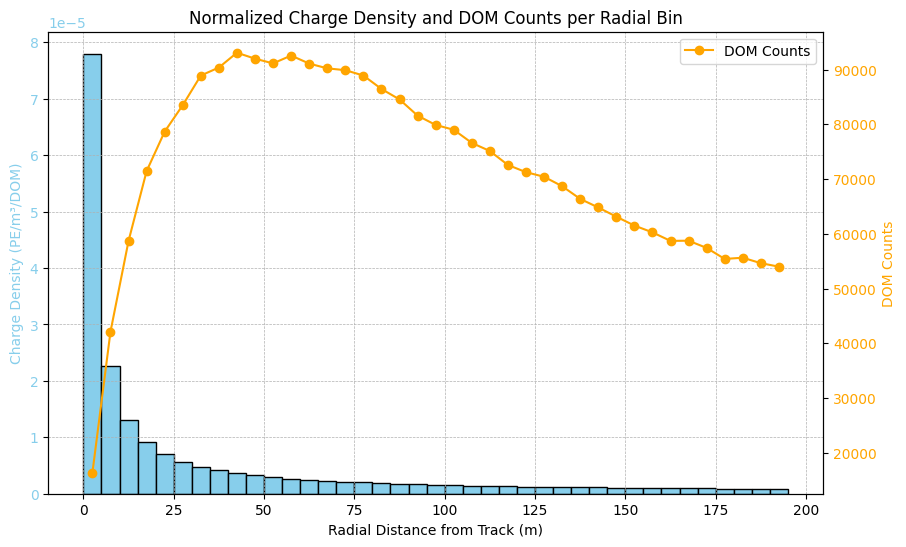

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate radial distances for DOMs from track
def calculate_radial_distance(dom_positions, P1, P2):
    muon_dir = P2 - P1
    muon_dir_unit = muon_dir / np.linalg.norm(muon_dir)
    vec_P1_DOM = dom_positions - P1
    projection_lengths = np.dot(vec_P1_DOM, muon_dir_unit)
    P_closest = P1 + np.outer(projection_lengths, muon_dir_unit)
    radial_distances = np.linalg.norm(dom_positions - P_closest, axis=1)
    return radial_distances

# Parameters
radial_bins = np.arange(0, 200, 5)  # Radial bins (in meters)
charge_density = np.zeros(len(radial_bins) - 1)
dom_counts = np.zeros(len(radial_bins) - 1)  # To count DOMs per radial bin
muon_track_length = 200  # Track length (in meters)

# Loop through events and accumulate charge density
for event_no, event_data in df_splits.groupby('event_no'):
    primary_data = df_truth[df_truth['event_no'] == event_no]
    if primary_data.empty:
        continue
    
    P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
    zenith, azimuth, track_length = primary_data[['zenith', 'azimuth', 'track_length']].values[0]
    P2 = P1 + track_length * np.array([np.sin(zenith) * np.cos(azimuth), np.sin(zenith) * np.sin(azimuth), np.cos(np.pi - zenith)])

    # Get DOM positions and charges
    dom_positions = event_data[['dom_x', 'dom_y', 'dom_z']].values
    charges = event_data['charge'].values

    # Calculate radial distances
    radial_distances = calculate_radial_distance(dom_positions, P1, P2)
    
    # Bin charges and DOM counts based on radial distances
    hist, _ = np.histogram(radial_distances, bins=radial_bins, weights=charges)
    dom_count, _ = np.histogram(radial_distances, bins=radial_bins)
    
    charge_density += hist
    dom_counts += dom_count

# Calculate the cylindrical volume for each radial bin
bin_volumes = np.pi * (radial_bins[1:]**2 - radial_bins[:-1]**2) * muon_track_length

# Normalize the charge density by volume and DOM count
normalized_charge_density = charge_density / (bin_volumes * np.maximum(dom_counts, 1))  # Avoid division by zero

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot normalized charge density
ax1.bar(radial_bins[:-1], normalized_charge_density, width=np.diff(radial_bins), align='edge', color='skyblue', edgecolor='black')
ax1.set_xlabel('Radial Distance from Track (m)')
ax1.set_ylabel('Charge Density (PE/m³/DOM)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
#ax1.set_yscale('log')
ax1.set_title('Normalized Charge Density and DOM Counts per Radial Bin')
ax1.grid(True, which="both", ls="--", linewidth=0.5)

# Plot DOM counts on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(radial_bins[:-1] + np.diff(radial_bins) / 2, dom_counts, color='orange', marker='o', linestyle='-', label='DOM Counts')
ax2.set_ylabel('DOM Counts', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
#ax2.set_yscale('log')

# Show legend for the second y-axis
ax2.legend(loc='upper right')

plt.show()


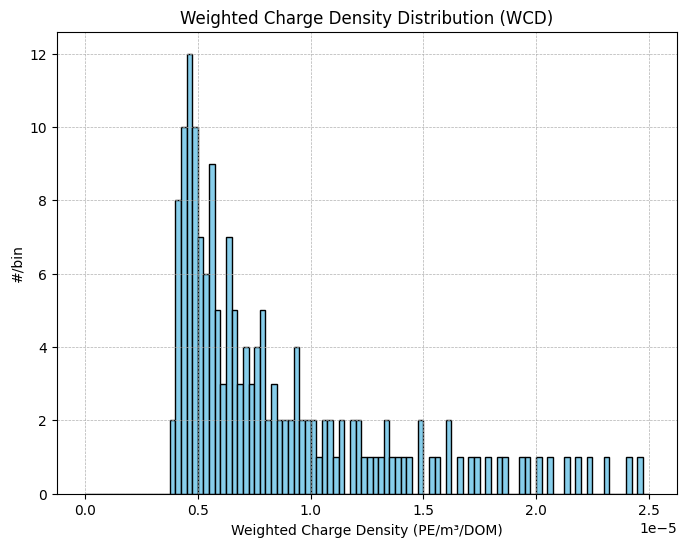

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate radial distance from the muon track to DOMs
def calculate_radial_distance(dom_positions, P1, P2):
    muon_dir = P2 - P1
    muon_dir_unit = muon_dir / np.linalg.norm(muon_dir)
    
    vec_P1_DOM = dom_positions - P1
    projection_lengths = np.dot(vec_P1_DOM, muon_dir_unit)
    P_closest = P1 + np.outer(projection_lengths, muon_dir_unit)
    
    radial_distances = np.linalg.norm(dom_positions - P_closest, axis=1)
    return radial_distances

# Define parameters
muon_track_length = 200  # 200m track length
radial_bins = np.arange(0, 200, 1)  # Bins for radial distance in meters

# Variables to accumulate charge and DOM count per radial distance bin
charge_density = np.zeros(len(radial_bins) - 1)
dom_counts = np.zeros(len(radial_bins) - 1)

# Loop through events and accumulate charge density
for event_no, event_data in df_splits.groupby('event_no'):
    primary_data = df_truth[df_truth['event_no'] == event_no]
    if primary_data.empty:
        continue
    
    P1 = primary_data[['position_x', 'position_y', 'position_z']].values[0]
    zenith, azimuth, track_length = primary_data[['zenith', 'azimuth', 'track_length']].values[0]
    P2 = P1 + track_length * np.array([np.sin(zenith) * np.cos(azimuth), np.sin(zenith) * np.sin(azimuth), np.cos(np.pi - zenith)])
    # Get DOM positions and charges
    dom_positions = event_data[['dom_x', 'dom_y', 'dom_z']].values
    charges = event_data['charge'].values# / 1.35  # Scale charges if needed
    
    # Calculate radial distances
    radial_distances = calculate_radial_distance(dom_positions, P1, P2)
    
    # Bin charges and DOM counts based on radial distances
    hist, _ = np.histogram(radial_distances, bins=radial_bins, weights=charges)
    dom_count, _ = np.histogram(radial_distances, bins=radial_bins)
    
    charge_density += hist
    dom_counts += dom_count

# Calculate cylindrical volume per bin
bin_volumes = np.pi * (radial_bins[1 :]**2 - radial_bins[:-1]**2) * muon_track_length

# Normalize the charge density by volume and DOM count
normalized_charge_density = charge_density / (bin_volumes * np.maximum(dom_counts, 1))

# Plot the histogram with a logarithmic scale on the y-axis
plt.figure(figsize=(8, 6))
plt.hist(normalized_charge_density, bins=100,range = (0,2.5e-5) , color='skyblue', edgecolor='black', log=False)
plt.xlabel('Weighted Charge Density (PE/m³/DOM)')

plt.ylabel('#/bin')
plt.title('Weighted Charge Density Distribution (WCD)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


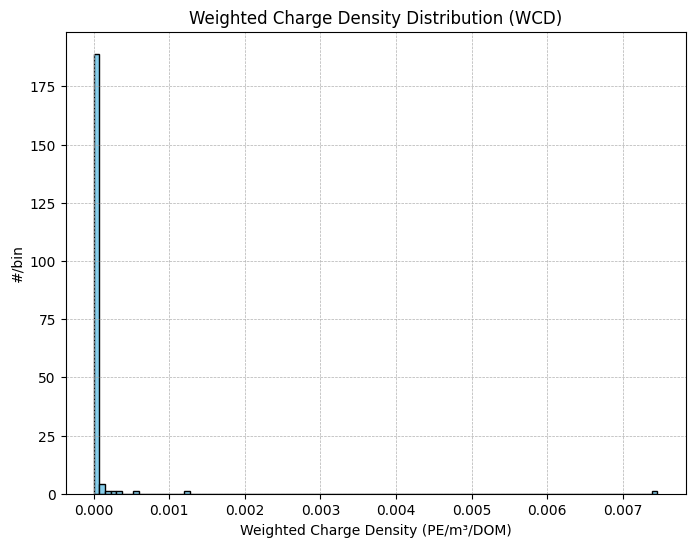

In [11]:
# Plot the histogram with a logarithmic scale on the y-axis
plt.figure(figsize=(8, 6))
plt.hist(normalized_charge_density, bins=100, color='skyblue', edgecolor='black', log=False)
plt.xlabel('Weighted Charge Density (PE/m³/DOM)')
#plt.xlim(0, 2.5e-4)
plt.ylabel('#/bin')
plt.title('Weighted Charge Density Distribution (WCD)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


In [69]:
def calculate_zenith_angles(dom_positions, P1, P2):
    # Calculate the vector of the muon track (P2 - P1) and normalize it
    muon_direction = P2 - P1
    muon_direction /= np.linalg.norm(muon_direction)  # Normalize the direction
    
    # Calculate the vector from P1 to each DOM
    dom_vectors = dom_positions - P1
    
    # Calculate the dot product between the DOM vectors and the muon track direction
    dot_products = np.dot(dom_vectors, muon_direction)
    
    # Calculate the magnitudes of the DOM vectors and the muon direction
    dom_magnitudes = np.linalg.norm(dom_vectors, axis=1)
    
    # Use the dot product and magnitudes to calculate the cosine of the zenith angle
    cos_zenith_angles = dot_products / dom_magnitudes
    
    # Clamp values to the range [-1, 1] to avoid numerical errors in arccos
    cos_zenith_angles = np.clip(cos_zenith_angles, -1.0, 1.0)
    
    # Calculate the zenith angles in radians
    zenith_angles = np.arccos(cos_zenith_angles)
    
    return zenith_angles


Sample NQE DOM positions and calculated RIDE_NQE values:
        dom_x      dom_y       dom_z    charge  RIDE_NQE
0  -77.800000 -54.330000 -467.480000  0.993904  0.868611
5   26.956667 -31.191250 -380.177000  0.769526  0.933070
6   26.831633 -31.243041 -418.991473  1.298131  1.125066
7   62.623333 -35.163750 -461.177000  0.530389  0.847941
8   62.623333 -35.087664 -467.074662  1.030810  1.219636
9   89.290000 -58.998750 -440.177000  0.387277  0.950324
10  89.290000 -58.998750 -478.683000  1.504072  1.305211
11  47.341791 -57.137534 -418.868527  1.385642  0.969805
12  47.290000 -57.012500 -479.177000  0.913178  1.108809
14  18.238209 -50.928716 -445.868527  1.541796  1.244368
Sample HQE DOM positions and calculated RIDE_HQE values:
    dom_x  dom_y   dom_z    charge  RIDE_HQE
1   -9.68 -79.50 -464.79  1.165534  0.980157
2   -9.68 -79.50 -478.81  0.871848  0.838172
3  -10.97   6.72 -437.34  0.974104  0.940533
4  -10.97   6.72 -451.36  1.283981  1.101532
18  46.29 -34.88 -435.17  0.778469

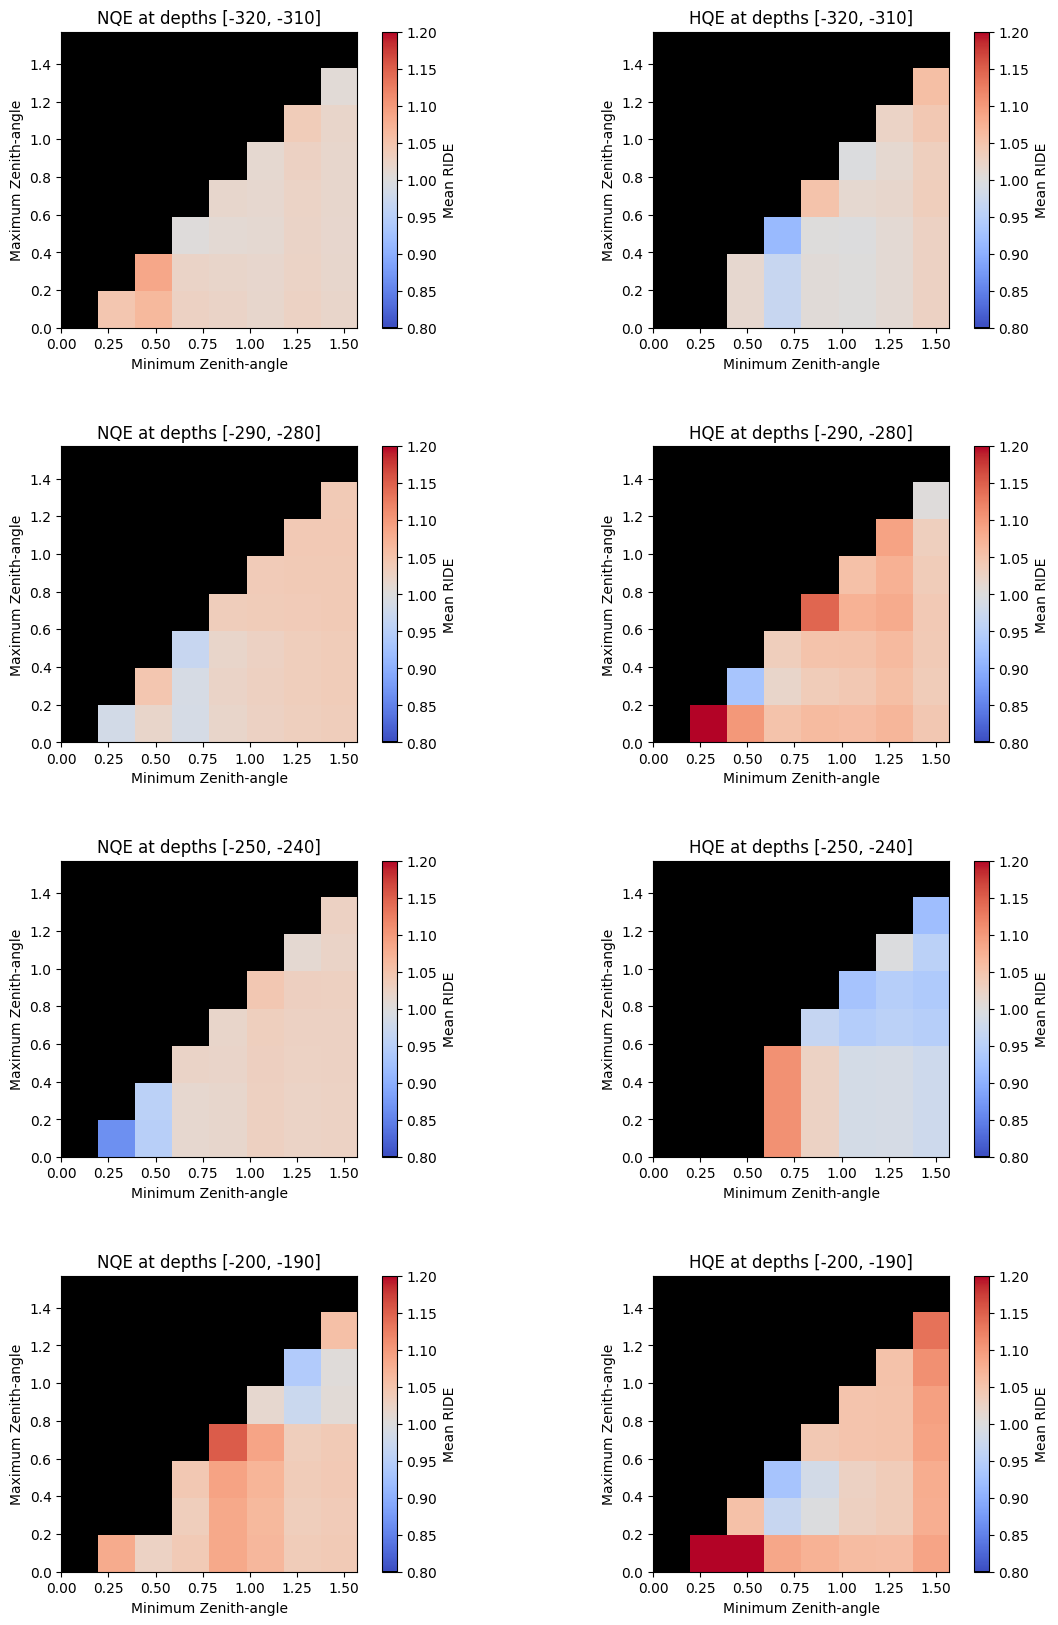

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define continuous 10-meter depth bins from -500m to 0m
all_depth_bins = np.arange(-500, 0, 10)
df_splits['depth_bin'] = pd.cut(df_splits['dom_z'], bins=all_depth_bins, labels=all_depth_bins[:-1])

# Initialize columns for 'RIDE_NQE' and 'RIDE_HQE' with NaN values
df_splits['RIDE_NQE'] = np.nan
df_splits['RIDE_HQE'] = np.nan

# Define specific depth ranges for focused plots
focus_depth_bins = [(-320, -310), (-290, -280), (-250, -240), (-200, -190)]

# Separate data for NQE and HQE based on 'rde' values
nqe_group = df_splits[df_splits['rde'] == 1.0]  # Only DOMs with rde = 1.0 for NQE
hqe_group = df_splits[df_splits['rde'] == 1.35]  # Only DOMs with rde = 1.35 for HQE

# Step 1: Calculate the monitor value (median NQE charge per hit) for each depth bin
monitor_values = {}
grouped_nqe = nqe_group.groupby('depth_bin', observed=False)

for bin, group in grouped_nqe:
    dom_indices_nqe = np.unique(group[['dom_x', 'dom_y', 'dom_z']].values, axis=0, return_inverse=True)[1]
    total_charge_per_dom_nqe = np.bincount(dom_indices_nqe, weights=group['charge'].values)
    hit_count_per_dom_nqe = np.bincount(dom_indices_nqe, weights=np.ones_like(group['event_no'].values))
    
    # Calculate average charge per hit for NQE DOMs
    avg_charge_per_hit_nqe = total_charge_per_dom_nqe / hit_count_per_dom_nqe
    
    # Store the median value for this depth bin in the monitor_values dictionary
    if len(avg_charge_per_hit_nqe) > 0:
        monitor_values[bin] = np.median(avg_charge_per_hit_nqe)

    else:
        monitor_values[bin] = 0

# Step 2: Calculate total charge and number of events for each DOM for both NQE and HQE
dom_positions_nqe = nqe_group[['dom_x', 'dom_y', 'dom_z']].values
dom_positions_hqe = hqe_group[['dom_x', 'dom_y', 'dom_z']].values

charges_nqe = nqe_group['charge'].values
charges_hqe = hqe_group['charge'].values

events_nqe = nqe_group['event_no'].values
events_hqe = hqe_group['event_no'].values

depth_bins_nqe = nqe_group['depth_bin'].values
depth_bins_hqe = hqe_group['depth_bin'].values

# Unique DOMs for NQE and HQE
unique_doms_nqe, dom_indices_nqe = np.unique(dom_positions_nqe, axis=0, return_inverse=True)
unique_doms_hqe, dom_indices_hqe = np.unique(dom_positions_hqe, axis=0, return_inverse=True)

# Total charge for NQE DOMs (sum over all events the DOM is part of)
total_charge_per_dom_nqe = np.bincount(dom_indices_nqe, weights=charges_nqe)

# Count the number of unique events each DOM participated in (this is now the number of events, not hits)
event_count_per_dom_nqe = np.bincount(dom_indices_nqe, weights=np.ones_like(events_nqe))

# Average charge per event for each NQE DOM
avg_charge_per_event_nqe = total_charge_per_dom_nqe / event_count_per_dom_nqe

# Step 3: Calculate the monitor value (median NQE average charge per event) for each depth bin
monitor_per_dom_nqe = np.array([monitor_values.get(float(bin), np.nan) for bin in depth_bins_nqe[dom_indices_nqe[:len(unique_doms_nqe)]]])

# Step 4: Calculate RIDE for NQE DOMs using the monitor value
valid_monitor_mask_nqe = (monitor_per_dom_nqe != 0) & (~np.isnan(monitor_per_dom_nqe))
ride_nqe_values = np.full_like(avg_charge_per_event_nqe, np.nan)
ride_nqe_values[valid_monitor_mask_nqe] = avg_charge_per_event_nqe[valid_monitor_mask_nqe] / monitor_per_dom_nqe[valid_monitor_mask_nqe]

df_splits.loc[nqe_group.index, 'RIDE_NQE'] = ride_nqe_values[dom_indices_nqe]

# Repeat the process for HQE DOMs (using the monitor from NQE DOMs)

# Total charge for HQE DOMs
total_charge_per_dom_hqe = np.bincount(dom_indices_hqe, weights=charges_hqe)

# Count the number of unique events each HQE DOM participated in
event_count_per_dom_hqe = np.bincount(dom_indices_hqe, weights=np.ones_like(events_hqe))

# Average charge per event for each HQE DOM
avg_charge_per_event_hqe = total_charge_per_dom_hqe / event_count_per_dom_hqe

# Use the same NQE monitor values
monitor_per_dom_hqe = np.array([monitor_values.get(float(bin), np.nan) for bin in depth_bins_hqe[dom_indices_hqe[:len(unique_doms_hqe)]]])

valid_monitor_mask_hqe = (monitor_per_dom_hqe != 0) & (~np.isnan(monitor_per_dom_hqe))
ride_hqe_values = np.full_like(avg_charge_per_event_hqe, np.nan)
ride_hqe_values[valid_monitor_mask_hqe] = avg_charge_per_event_hqe[valid_monitor_mask_hqe] / monitor_per_dom_hqe[valid_monitor_mask_hqe]

df_splits.loc[hqe_group.index, 'RIDE_HQE'] = ride_hqe_values[dom_indices_hqe]

print(f"Sample NQE DOM positions and calculated RIDE_NQE values:\n{df_splits[df_splits['rde'] == 1.0][['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE_NQE']].head(10)}")
print(f"Sample HQE DOM positions and calculated RIDE_HQE values:\n{df_splits[df_splits['rde'] == 1.35][['dom_x', 'dom_y', 'dom_z', 'charge', 'RIDE_HQE']].head(10)}")

# Now the plotting part:
# Define color scale limits
nqe_vmin, nqe_vmax = 0.8, 1.2
hqe_vmin, hqe_vmax = 0.8, 1.2
min_distance_bins = np.arange(0, np.pi/2, 0.2)
max_distance_bins = np.arange(0, np.pi/2, 0.2)
fig, axs = plt.subplots(4, 2, figsize=(14, 20)) 
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for depth_idx, (depth_min, depth_max) in enumerate(focus_depth_bins):
    for eff_label, data in {"NQE": df_splits[df_splits['RIDE_NQE'].notnull()],
                            "HQE": df_splits[df_splits['RIDE_HQE'].notnull()]}.items():
        data_filtered = data[(data['dom_z'] >= depth_min) & (data['dom_z'] <= depth_max)]
        
        
        dom_positions = data_filtered[['dom_x', 'dom_y', 'dom_z']].values
        
        ride_grid = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        ride_grid_counts = np.zeros((len(min_distance_bins), len(max_distance_bins)))
        total_events = 0
        total_doms = 0
        for event_no, event_data in data_filtered.groupby('event_no'):
            primary_data = df_primary[df_primary['Prim_EventID'] == event_no]
            total_events += 1
            if primary_data.empty:
                continue
            P1 = primary_data[['X_position_Prim', 'Y_position_Prim', 'Z_position_Prim']].values[0]
            zenith, azimuth = primary_data['Zenith_Prim'].values[0], primary_data['Azimuth_Prim'].values[0]
            P2 = P1 + muon_track_length * np.array([
                np.sin(zenith) * np.cos(azimuth),
                np.sin(zenith) * np.sin(azimuth),
                np.cos(zenith)
            ])
            
            ride_values = data_filtered['RIDE_NQE'].values if eff_label == "NQE" else data_filtered['RIDE_HQE'].values
            zenith_angles = calculate_zenith_angles(dom_positions, P1, P2)
            total_doms += len(zenith_angles)

            for i, dom_dist in enumerate(zenith_angles):
                ride_value = ride_values[i]
                if not np.isnan(ride_value):
                    # Populate lower triangular region (min_dist_bin <= max_dist_bin)
                    for min_dist_bin in range(len(min_distance_bins)):
                        for max_dist_bin in range(min_dist_bin, len(max_distance_bins)):
                            min_dist = min_distance_bins[min_dist_bin]
                            max_dist = max_distance_bins[max_dist_bin]
                            if min_dist <= dom_dist <= max_dist:
                                ride_grid[min_dist_bin, max_dist_bin] += ride_value
                                ride_grid_counts[min_dist_bin, max_dist_bin] += 1

        # Normalize the RIDE grid by the number of contributions
        ride_grid = np.divide(ride_grid, ride_grid_counts, out=np.zeros_like(ride_grid), where=ride_grid_counts != 0)
        print(f"Depth bin [{depth_min}, {depth_max}], Efficiency group: {eff_label}, Total contributing events: {total_events}, Total DOMs: {total_doms}")
        # Custom colormap to show zeros as black
        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.arange(cmap.N))
        colors[0] = np.array([0, 0, 0, 1])  # Set first color (zero) to black
        custom_cmap = mcolors.ListedColormap(colors)

        # Mask zero values
        ride_grid_masked = np.ma.masked_where(ride_grid == 0, ride_grid)

        # Plot with imshow
        ax = axs[depth_idx, 0 if eff_label == "NQE" else 1]
        im = ax.imshow(
            ride_grid_masked,
            cmap=custom_cmap, origin='lower',
            vmin=(nqe_vmin if eff_label == "NQE" else hqe_vmin),
            vmax=(nqe_vmax if eff_label == "NQE" else hqe_vmax),
            extent=[0, np.pi/2, 0, np.pi/2]
        )
        ax.set_facecolor('black')
        ax.set_title(f"{eff_label} at depths [{depth_min}, {depth_max}]")
        ax.set_xlabel("Minimum Zenith-angle")
        ax.set_ylabel("Maximum Zenith-angle")
        fig.colorbar(im, ax=ax, label="Mean RIDE")

plt.show()
